# п.1 Общая обработка
## В этой части ввожу необходимые для работы библиотеки, загружаю внешние данные, удаляю дубликаты и соединяю файлы в общую рабочую область. Ввиду технической проблемы сокращаю рандомно датасет на 70% для возможности анализа и обработки данных. Учитывая, что датасет распределен неравномерно, а именно, количество благоприятной целевой переменной равна 0,65%, то делаю вывод что анализ не будет искажен.

In [40]:
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Загрузка данных
sessions = pd.read_pickle('ga_sessions.pkl')
hits = pd.read_pickle('ga_hits.pkl')

In [ ]:
sessions.drop_duplicates(inplace=True)
hits.drop_duplicates(inplace=True)

In [ ]:
data = sessions.merge(hits, on='session_id', how='left')

In [ ]:
data.to_csv('step_1.csv', index=False)

In [ ]:
data=pd.read_csv('step_1.csv', low_memory=False)

In [ ]:
reduced_data = data.sample(frac=0.3, random_state=42)  # Установка random_state для воспроизводимости
#Выводим размер нового датасета
print(f'Изначальный размер: {data.shape[0]}')
print(f'Размер сокращенного датасета: {reduced_data.shape[0]}')
#Cохраняем сокращенный датасет
reduced_data.to_csv('reduced_data.csv', index=False) 

In [42]:
data=pd.read_csv('reduced_data.csv', low_memory=False)

# п.2 В этом блоке считаю количество NaN значений, оставшихся после общей обработки

In [4]:
na_count = data.isna().sum()
na_with_values = na_count[na_count > 0]
print(na_with_values)

utm_source            221
utm_campaign       666576
utm_adcontent      858235
utm_keyword       2780369
device_os         2764894
device_brand      1189858
device_model      4706810
hit_date            38442
hit_time          2787049
hit_number          38442
hit_type            38442
hit_referer       1908034
hit_page_path       38442
event_category      38442
event_action        38442
event_label       1157042
event_value       4743898
dtype: int64


# Сводная таблица

| Название колонки | Количество значений NaN |
|---|:---|
| utm_source|221|
| utm_campaign|666576|
| utm_adcontent|858235| 
| utm_keyword|2780369| 
| device_os|2764894|
| device_brand|1189858| 
| device_model|4706810| 
| hit_date|38442| 
| hit_time|2787049| 
| hit_number|38442| 
| hit_type|38442| 
| hit_referer|1908034| 
| hit_page_path|38442| 
| event_category|38442| 
| event_action|38442| 
| event_label|1157042| 
| event_value|4743898| 
|  |  |  

# п.3 Для начала работы определим целевую переменную target по условиям задания

In [43]:
# Определяем целевые действия
target_actions = [
    'sub_car_claim_click', 'sub_car_claim_submit_click', 
    'sub_open_dialog_click', 'sub_custom_question_submit_click', 
    'sub_call_number_click', 'sub_callback_submit_click', 
    'sub_submit_success', 'sub_car_request_submit_click'
]

# Создаем целевую переменную
data['target'] = data['event_action'].isin(target_actions).astype(int)

## Проверяю строки на NaN, на наличие категорий, которые могли бы быть неверно написаны из смежного столбца и где значения целевой переменной равно 0. В случае совпадения мне бы вывело строки, которые возможно относятся к целевой переменной для балансировки на положительный результат

In [44]:
# Фильтрация строк по условиям
filtered_data = data[
    data['event_action'].isna() &  # event_action равно NaN
    data['event_category'].isin(['sub_button_click', 'sub_submit']) &  # event_category в заданном списке
    (data['target'] == 0)  # target равно 0
]

# Вывод отфильтрованных строк
print(filtered_data)

Empty DataFrame
Columns: [session_id, client_id, visit_date, visit_time, visit_number, utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword, device_category, device_os, device_brand, device_model, device_screen_resolution, device_browser, geo_country, geo_city, hit_date, hit_time, hit_number, hit_type, hit_referer, hit_page_path, event_category, event_action, event_label, event_value, target]
Index: []

[0 rows x 29 columns]


## Как мы видим, таких значений нет, значит все благоприятные исходы нами указаны и количество их верное. Категорирую остальные значения данного столбца с целевой переменной в значения которые нам нужны, как благоприятные и на "неопределенно" для резервирования вычислительных возможностей

In [45]:
data.loc[data['target'] == 0, 'event_action'] = 'unknown'

# Вывожу результат обработки колонки с целевой переменной

In [7]:
# Подсчет количества 1 и 0 в колонке 'target'
value_counts = data['target'].value_counts()

# Вывод результатов
count_1 = value_counts.get(1, 0)  # Получаем количество 1, если оно есть, иначе 0
count_0 = value_counts.get(0, 0)  # Получаем количество 0, если оно есть, иначе 0

print(f'Количество 1 в колонке target: {count_1}')
print(f'Количество 0 в колонке target: {count_0}')

Количество 1 в колонке target: 30643
Количество 0 в колонке target: 4713255


# Таблица результатов

| Описание | Значение|
|---|:---|
| Количество 1 в колонке target|30643|
| Количество 0 в колонке target|4713255|
|  |  |  

## Как мы видим, датасет несбалансирован и количество благоприятных исходов составляет менее 1%

# Визуализирую результаты

In [57]:
def plot_countplot_target(data, x_col, title='Объем целевых действий за время пользования ресурсом', xlabel='Целевое действие', ylabel='Количество'):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Вывожу визуализацию

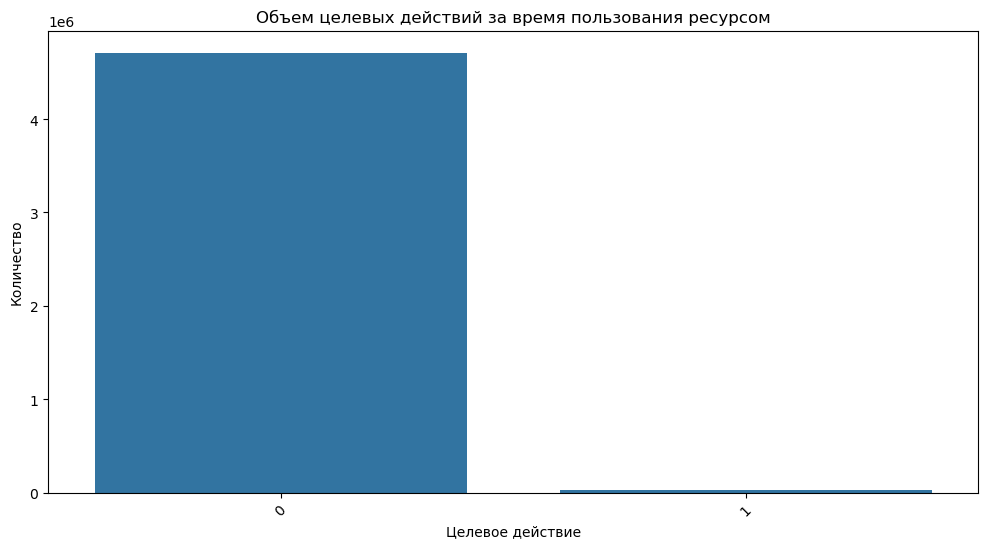

In [64]:
plot_countplot_target(data, 'target')

# п.4 Провожу анализ колонки utm_source согласно таблицы, которую я указал в п.2

In [9]:
data.utm_source.value_counts   

<bound method IndexOpsMixin.value_counts of 0          fDLlAcSmythWSCVMvqvL
1          kjsLglQLzykiRbcDiGcD
2          ZpYIoDJMcFzVoPFsHGJL
3          ZpYIoDJMcFzVoPFsHGJL
4          ZpYIoDJMcFzVoPFsHGJL
                   ...         
4743893    fDLlAcSmythWSCVMvqvL
4743894    MvfHsxITijuriZxsqZqt
4743895    kjsLglQLzykiRbcDiGcD
4743896    QxAxdyPLuQMEcrdZWdWb
4743897    fDLlAcSmythWSCVMvqvL
Name: utm_source, Length: 4743898, dtype: object>

## Проверив колонку на уникальность мы видим большое множество уникальных значений. Выведем их список

In [73]:
unique_values = data['utm_source'].unique()
print("Уникальные значения в 'utm_source':", unique_values)

Уникальные значения в 'utm_source': ['fDLlAcSmythWSCVMvqvL' 'kjsLglQLzykiRbcDiGcD' 'ZpYIoDJMcFzVoPFsHGJL'
 'bByPQxmDaMXgpHeypKSM' 'BHcvLfOaCWvWTykYqHVe' 'vFcAhRxLfOWKhvxjELkx'
 'QxAxdyPLuQMEcrdZWdWb' 'aXQzDWsJuGXeBXexNHjc' 'RmEBuqrriAfAVsLQQmhk'
 'dyicZQGoeASogoSafjEh' 'MvfHsxITijuriZxsqZqt' 'jaSOmLICuBzCFqHfBdRg'
 'IZEXUFLARCUMynmHNBGo' 'BKeImrJuRDZcHiSSTdzm' 'fgymSoTvjKPEgaIJqsiH'
 'iNFgfQPqHPBuvGCYtrQE' 'hTjLvqNxGggkGnxSCaTm' 'eLzNJHzPelJpEyBwMrKo'
 'ISrKoXQCxqqYvAZICvjs' 'oZCzWSykfixnjMPDNjSU' 'nrKihqcWGIzDsOqljdAv'
 'PlbkrSYoHuZBWfYjYnfw' 'faqsogjxCvbseFqupueU' 'EvhrtRzIJnQYHziPiLzV'
 'GpAkIXsclxDGyILfNlrR' 'nSReTmyFtbSjlPrTKoaX' 'YlsczTIyBSwTLNtuDkCd'
 'qVXuCoVQtPxcUkAXiXBa' 'KgicpPxiEQfzPlPwQZJq' 'nmfptFmSirEqNzAzqbXA'
 'SzZERoLMmrEUEhDaYcyN' 'DnEUulZAecfGPvdtZBYS' 'ySpKPVDYCgmkHVSeLjnJ'
 'gVRrcxiDQubJiljoTbGm' 'WeIwsqEbpZGZwhcQktNS' 'WEXkMlsnJodrzBgKJBpG'
 'LIWKeifdTCbuNeniIUqm' 'YclHumxPxSxgzHfvCaeF' 'FTAuYVNoYYxgvKMpKSLW'
 'gDBGzjFKYabGgSPZvrDH' 'GkGprIZHXAKqgsyDIvMR' 'TxKUcP

## Как мы видим, колонку необоходимо стандартизировать и убрать nan
Посчитаем вхождение в колонку целевой переменной

In [10]:
# Группируем по utm_source и суммируем целевые значения
source_counts = data.groupby('utm_source')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_source = source_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_source)

               utm_source  target
132  ZpYIoDJMcFzVoPFsHGJL    9557
160  fDLlAcSmythWSCVMvqvL    6026
188  kjsLglQLzykiRbcDiGcD    4038
140  bByPQxmDaMXgpHeypKSM    3567
5    BHcvLfOaCWvWTykYqHVe    2543
66   MvfHsxITijuriZxsqZqt    1324
137  aXQzDWsJuGXeBXexNHjc    1112
81   QxAxdyPLuQMEcrdZWdWb     939
185  jaSOmLICuBzCFqHfBdRg     230
208  oZCzWSykfixnjMPDNjSU     150


## Видим, что, по первой категории доля вхождений составляет 31%, что довольно велико
В представленном списке количество вхождений целевой переменной достигает 29 486 значений, что составляет 96% общего числа благоприятных условий.\
Соответственно, остальные значения нам не особо интересны.\
Выделим категории для упрощения обработки столбца и создадим дополнительный, для повышения уровня обученности модели в дальнейшем.\
Не забудем учесть из условий задачи, что в этой колонке присутствую социальные ресурсы, которые нужно рассмотреть отдельно

In [92]:
# Определяем функцию для присвоения категорий
def classify_utm_source(source):
    high = ['ZpYIoDJMcFzVoPFsHGJL', 'fDLlAcSmythWSCVMvqvL']
    medium = ['kjsLglQLzykiRbcDiGcD', 'bByPQxmDaMXgpHeypKSM', 'BHcvLfOaCWvWTykYqHVe', 'aXQzDWsJuGXeBXexNHjc']
    social_sources = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
                      'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']
    if source in high:
        return 'high'
    elif source in medium:
        return 'medium'
    elif source in social_sources:
        return 'social'
    else:
        return 'low'

# Применяем функцию для создания новой колонки utm_source_classification
data['utm_source_classification'] = data['utm_source'].apply(classify_utm_source)

In [93]:
# Создание промежуточной колонки source_target
def assign_source_target(row):
    if row['utm_source_classification'] in ['high', 'medium', 'social']:
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки source_target
data['source_target'] = data.apply(assign_source_target, axis=1)

## Создав дополнительную колонку мы можем легко категорировать переменные в более экономичный вариант
Заменяем все NaN на "неизвестно" и меняем значения, которые нам не интересны

In [95]:
# Замена NaN на 'unknown' в колонке utm_source
data['utm_source'] = data['utm_source'].fillna('unknown')

In [96]:
data.loc[data['source_target'] == 0, 'utm_source'] = 'unknown'

# Сводная таблица

| Колонка utm_source  | Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| ZpYIoDJMcFzVoPFsHGJL|9557|high|
| fDLlAcSmythWSCVMvqvL|6026|high|
| kjsLglQLzykiRbcDiGcD|4038|medium|
| bByPQxmDaMXgpHeypKSM|3567|medium|
| BHcvLfOaCWvWTykYqHVe|2543|medium|
| MvfHsxITijuriZxsqZqt|1324|social|
| aXQzDWsJuGXeBXexNHjc|1112|medium|
| QxAxdyPLuQMEcrdZWdWb|939|social|
| jaSOmLICuBzCFqHfBdRg|230|low|
| oZCzWSykfixnjMPDNjSU|150|low|
|  |  |  

# Визуализирую данные

In [102]:
def plot_countplot_source(data, x_col, title='Число сессий по источникам трафика', xlabel='Источник трафика', ylabel='Количество сессий'):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Визуализация

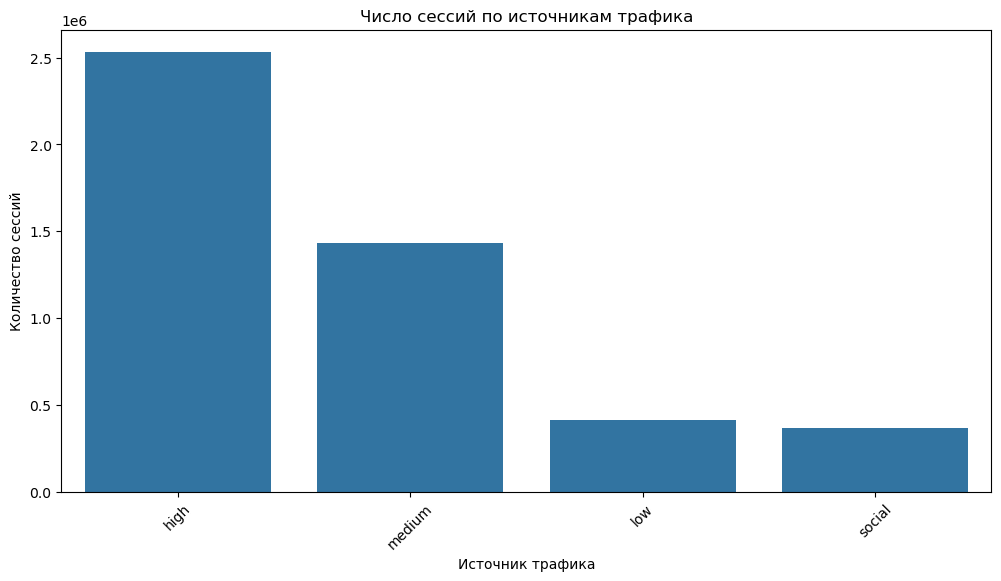

In [110]:
plot_countplot_source(data, 'utm_source_classification')

## Как мы можем видеть, категории действительно сгруппированы корректно, единственное, категория social выделяется на этом фоне. Как мы помним по анализу вхождения целевой переменной в social входит довольно крупные категории на 7% от общей доли всех попаданий целевой переменной, что нельзя игнорировать. Мы можем подсказать заказчику, что определенные категории выделяются на фоне остальных и тогда мы можем добавить данный массив в категорию high или medium, что сэкономит наши ресурсы

# п.5 Провожу анализ колонки utm_campaign
Ход работы не меняется, см. п.4

In [15]:
data.utm_campaign.value_counts   

<bound method IndexOpsMixin.value_counts of 0          LTuZkdKfxRGVceoWkVyg
1          LTuZkdKfxRGVceoWkVyg
2          LEoPHuyFvzoNfnzGgfcd
3          gecBYcKZCPMcVYdSSzKP
4          LEoPHuyFvzoNfnzGgfcd
                   ...         
4743893    LTuZkdKfxRGVceoWkVyg
4743894    FTjNLDyTrXaWYgZymFkV
4743895    LTuZkdKfxRGVceoWkVyg
4743896    PXQWdUxeUoXfoKzTBGpY
4743897    LTuZkdKfxRGVceoWkVyg
Name: utm_campaign, Length: 4743898, dtype: object>

In [117]:
unique_values = data['utm_campaign'].unique()
print("Уникальные значения в 'utm_campaign':", unique_values)

Уникальные значения в 'utm_campaign': ['LTuZkdKfxRGVceoWkVyg' 'LEoPHuyFvzoNfnzGgfcd' 'gecBYcKZCPMcVYdSSzKP' nan
 'FTjNLDyTrXaWYgZymFkV' 'nSReTmyFtbSjlPrTKoaX' 'okTXSMadDkjvntEHzIjp'
 'JdLDXLLzKXZlxBJrDTXh' 'emlBaVkgLVRqbEVOSSXt' 'DsqwamlMwRgMTyspCjFR'
 'XHNUiSKKGTEpSAlaVMFQ' 'KgicpPxiEQfzPlPwQZJq' 'TmThBvoCcwkCZZUWACYq'
 'MXqmDyetMTICSSitTjWV' 'jqlUOdZBNZYfInQVcZlS' 'MmyPhaRZgQtGHEnQbdUx'
 'RoDitORHdzGfGhNCyEMy' 'VBmazutCflYumtDHrQYe' 'UvuMsOSDBWQGOIbDbXfV'
 'QEejXfOCtOMFLZqIPApp' 'zxoiLxhuSIFrCeTLQVWZ' 'WlbWUObZWvsimzdFdLYw'
 'YCKgTzTDywjcWyQudGch' 'YDIkQmcjRkpdxGbLLtNN' 'GWZGdHKPgmZPNPwkJshU'
 'SgIUDYUKnyWHVowUOqid' 'foFTSdUvNqqkPzZvgiqt' 'jpjTolpOezlrOPAunDZi'
 'ascPqxFuFewWWZSVMpkh' 'iYBYglGljMDRQyqHRiPH' 'PXQWdUxeUoXfoKzTBGpY'
 'bxOTvPtyGSdUrbwoXCPO' 'vVspBWANjeNCTQJpJJeE' 'bgTYkDHjOsJzMUtoGhiQ'
 'hSkxjvIamxEAKPuQRbPZ' 'eimRuUrNhZLAYcwRrNXu' 'kVOrIKZFrEYGvixPclal'
 'zPJpddwzkFqLMSYgtDqy' 'QdLfySaGXolfTBSNVfHn' 'sbJRYgVfvcnqKJNDDYIr'
 'wpmatvDuiMutnvmNVPJo' 'WjjvSVHOFOxHwlNJQcyk' '

In [16]:
# Группируем по utm_campaign и суммируем целевые значения
campaign_counts = data.groupby('utm_campaign')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_campaigns = campaign_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_campaigns)

             utm_campaign  target
80   LTuZkdKfxRGVceoWkVyg   11238
77   LEoPHuyFvzoNfnzGgfcd    5475
244  gecBYcKZCPMcVYdSSzKP    2803
35   FTjNLDyTrXaWYgZymFkV    1397
334  sbJRYgVfvcnqKJNDDYIr     378
183  XHNUiSKKGTEpSAlaVMFQ     302
138  SgIUDYUKnyWHVowUOqid     208
85   LwJZxKuWmvOhPsaCeRjG     178
390  zxoiLxhuSIFrCeTLQVWZ     160
228  eimRuUrNhZLAYcwRrNXu     155


In [133]:
# Определяем функцию для присвоения категорий
def classify_media_code(code):
    high = ['LTuZkdKfxRGVceoWkVyg', 'LEoPHuyFvzoNfnzGgfcd']
    medium = ['gecBYcKZCPMcVYdSSzKP', 'FTjNLDyTrXaWYgZymFkV']
    
    if code in high:
        return 'high'
    elif code in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки media_company
data['media_company'] = data['utm_campaign'].apply(classify_media_code)

In [135]:
# Определяем функцию для создания media_target
def get_media_target(row):
    if (row['media_company'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки media_target
data['media_target'] = data.apply(get_media_target, axis=1)

In [136]:
data.loc[data['media_target'] == 0, 'utm_campaign'] = 'unknown'

# Сводная таблица

| Колонка utm_campaign | Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| LTuZkdKfxRGVceoWkVyg|11238|high|
| LEoPHuyFvzoNfnzGgfcd|5475|high|
| gecBYcKZCPMcVYdSSzKP|2803|medium|
| FTjNLDyTrXaWYgZymFkV|1397|medium|
| sbJRYgVfvcnqKJNDDYIr|378|low|
| XHNUiSKKGTEpSAlaVMFQ|302|low|
| SgIUDYUKnyWHVowUOqid|208|low|
| LwJZxKuWmvOhPsaCeRjG|178|low|
| zxoiLxhuSIFrCeTLQVWZ|160|low|
| eimRuUrNhZLAYcwRrNXu|155|low|
|  |  |  

# Визуализирую данные

In [148]:
def plot_pie_chart_campaign(data, column, title='Распределение рекламных компаний'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

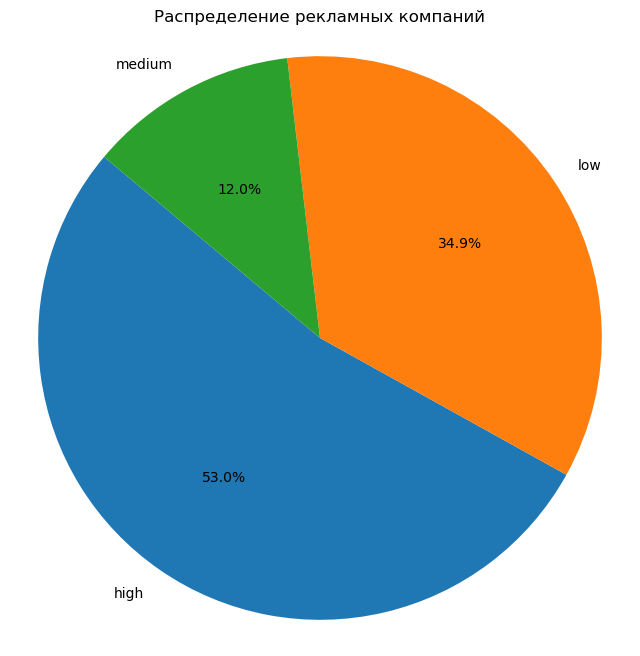

In [150]:
plot_pie_chart_campaign(data, 'media_company')

## Как мы видим на диаграмме, количество low категорий значительно превышает medium, делаем вывод что категории, за исключением тех, что мы отнесли к high, не имеют практического назначения и тратить на них ресурсы не стоит

# п.6 Провожу исследование колонки utm_adcontent
Ход исследования не меняется

In [20]:
data.utm_adcontent.value_counts       

<bound method IndexOpsMixin.value_counts of 0          JNHcPlZPxEMWDnRiyoBf
1          JNHcPlZPxEMWDnRiyoBf
2          vCIpmpaGBnIQhyYNkXqp
3          JNHcPlZPxEMWDnRiyoBf
4          JNHcPlZPxEMWDnRiyoBf
                   ...         
4743893    JNHcPlZPxEMWDnRiyoBf
4743894    xhoenQgDQsgfEPYNPwKO
4743895    JNHcPlZPxEMWDnRiyoBf
4743896                     NaN
4743897    JNHcPlZPxEMWDnRiyoBf
Name: utm_adcontent, Length: 4743898, dtype: object>

In [21]:
# Группируем по utm_adcontent и суммируем целевые значения
adcontent_counts = data.groupby('utm_adcontent')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_adcontents = adcontent_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_adcontents)

            utm_adcontent  target
44   JNHcPlZPxEMWDnRiyoBf   20330
232  vCIpmpaGBnIQhyYNkXqp    2331
248  xhoenQgDQsgfEPYNPwKO     661
80   PkybGvWbaqORmxjNunqZ     632
119  XSkXBCPfnJjvxbfeewtd      97
92   SOkCdPxfUcZUzzOdgGES      90
216  sYzBROYhjSDbFZCpzGyf      38
129  ZIMljraejFHmkkHvoNxk      37
142  dUuXlWzvmhDSyclWRhNP      35
4    AdeErYgVTbRcAWtHrMHq      35


In [159]:
# Определяем функцию для присвоения категорий
def classify_media_adcontents(adcontents):
    high = ['JNHcPlZPxEMWDnRiyoBf']
    medium = ['vCIpmpaGBnIQhyYNkXqp']
    
    if adcontents in high:
        return 'high'
    elif adcontents in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки media_adcontents
data['media_adcontents'] = data['utm_adcontent'].apply(classify_media_adcontents)

In [161]:
# Определяем функцию для создания media_adcontents_target
def get_media_adcontents(row):
    if (row['media_adcontents'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки media_adcontents_target
data['media_adcontents_target'] = data.apply(get_media_adcontents, axis=1)

In [162]:
data.loc[data['media_adcontents_target'] == 0, 'utm_adcontent'] = 'unknown'

# Сводная таблица

| Колонка utm_adcontent | Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| JNHcPlZPxEMWDnRiyoBf|20330|high|
| vCIpmpaGBnIQhyYNkXqp|2331|medium|
| xhoenQgDQsgfEPYNPwKO|661|low|
| PkybGvWbaqORmxjNunqZ|632|low|
| XSkXBCPfnJjvxbfeewtd|97|low|
| SOkCdPxfUcZUzzOdgGES|90|low|
| sYzBROYhjSDbFZCpzGyf|38|low|
| ZIMljraejFHmkkHvoNxk|37|low|
| dUuXlWzvmhDSyclWRhNP|35|low|
| AdeErYgVTbRcAWtHrMHq|35|low|
|  |  |  

# Визуализация данных

In [172]:
def plot_pie_chart_adcontent(data, column, title='Распределение источников данных'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализирую данные

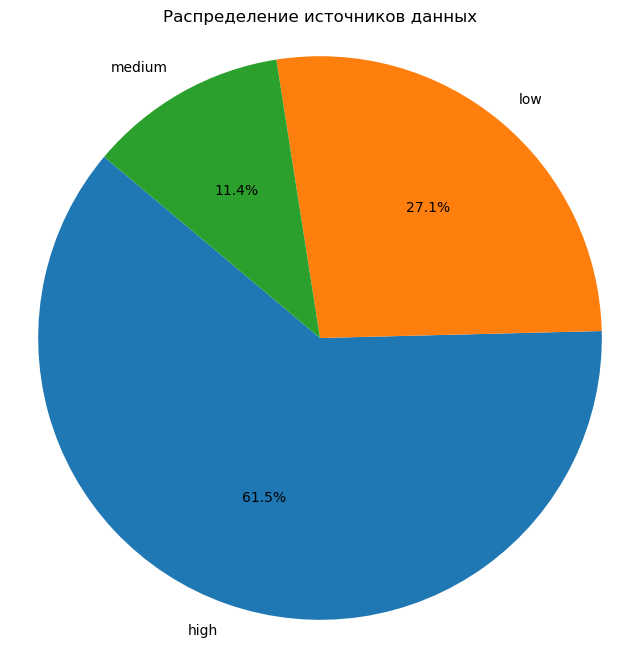

In [174]:
plot_pie_chart_adcontent(data, 'media_adcontents')

## Вывод в соответствии с п.5

# п.7 Провожу исследование колонки utm_keyword
Ход исследования не меняется

In [25]:
data.utm_keyword.value_counts      

<bound method IndexOpsMixin.value_counts of 0                           NaN
1                           NaN
2          puhZPIYqKXeFPaUviSjo
3                           NaN
4                           NaN
                   ...         
4743893                     NaN
4743894                     NaN
4743895    UKNBOHebRIIsQRsjNKay
4743896                     NaN
4743897                     NaN
Name: utm_keyword, Length: 4743898, dtype: object>

In [26]:
# Группируем по utm_keyword и суммируем целевые значения
keyword_counts = data.groupby('utm_keyword')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_keyword = keyword_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_keyword)

               utm_keyword  target
894   puhZPIYqKXeFPaUviSjo    7089
695   hAmNSZmQkKQKAjZEGlgb     543
175   ITfrGJNwVsHBGJMAKoct     228
424   UKNBOHebRIIsQRsjNKay     179
539   ZNhSIPchlbnKwZWcsKzz     137
377   RkpOyeEPgcMBSDuHLQcj      99
195   JTBldRAXvttfVmCNgppl      99
198   JajANoFxoqXfKRNBUhzx      92
810   mIKayglJaKQZvgdtLfqT      82
1061  xkXwwebfDFpZOOKBcXpE      69


In [181]:
# Определяем функцию для присвоения категорий
def classify_media_keyword(keyword):
    high = ['puhZPIYqKXeFPaUviSjo']
    
    if keyword in high:
        return 'high'
    else:
        return 'low'

# Применяем функцию для создания новой колонки media_keyword
data['media_keyword'] = data['utm_keyword'].apply(classify_media_keyword)

In [ ]:
# Определяем функцию для создания media_keyword_target
def get_media_keyword(row):
    if (row['media_keyword'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки media_keyword_target
data['media_keyword_target'] = data.apply(get_media_keyword, axis=1)

In [ ]:
data.loc[data['media_keyword_target'] == 0, 'utm_keyword'] = 'unknown'

# Сводная таблица

| Колонка utm_keyword | Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| puhZPIYqKXeFPaUviSjo|7089|high|
| hAmNSZmQkKQKAjZEGlgb|543|medium|
| ITfrGJNwVsHBGJMAKoct|228|low|
| UKNBOHebRIIsQRsjNKay|179|low|
| ZNhSIPchlbnKwZWcsKzz|137|low|
| RkpOyeEPgcMBSDuHLQcj|99|low|
| JTBldRAXvttfVmCNgppl|99|low|
| JajANoFxoqXfKRNBUhzx|92|low|
| mIKayglJaKQZvgdtLfqT|82|low|
| xkXwwebfDFpZOOKBcXpE|69|low|
|  |  |  

# Визуализирую данные

In [188]:
def plot_pie_chart_keyword(data, column, title='Распределение ключевых слов'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

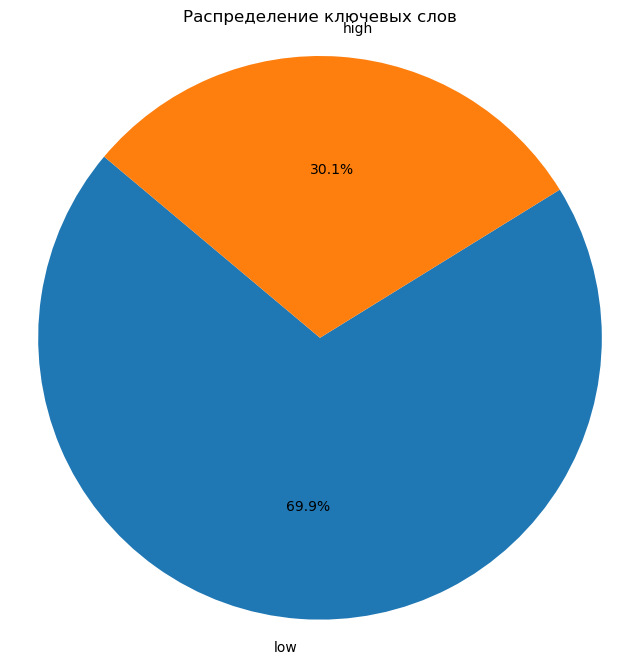

In [191]:
plot_pie_chart_keyword(data, 'media_keyword')

## В данном исследовании мы видим, что значение, которое относятся к наиболее результативному занимает 30% всего исследования, что достаточно велико. Но я бы не рекомендовал дальнейшее финансирование данных ресурсов

# п.8 Провожу исследование колонки device_brand
Ход исследования остается прежним

In [30]:
data.device_brand.value_counts()

device_brand
Apple        1426434
Samsung       789228
Xiaomi        627208
Huawei        414796
Realme         43178
              ...   
Mobiistar          1
Dynamic            1
Digiland           1
Tonbux             1
MTS                1
Name: count, Length: 174, dtype: int64

In [31]:
# Группируем по device_brand и суммируем целевые значения
brand_counts = data.groupby('device_brand')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_brand = brand_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_brand)

    device_brand  target
9          Apple    8484
128      Samsung    6022
166       Xiaomi    4056
68        Huawei    2680
127       Realme     279
0      (not set)     269
111         OPPO     235
156         Vivo     216
133         Sony      92
12          Asus      90


## Видим категорию (not set) которую необходимо отности к чему-то для повышения результативности. Я предположил, что это телефоны марки Huawei по причине сильного отставания от его не менее популярного товарища

In [203]:
data['device_brand'] = data['device_brand'].replace('(not set)', 'Huawei')
# Определяем функцию для присвоения категорий
def classify_brand(brand):
    high = ['Apple','Samsung','Xiaomi','Huawei','(not set)']
    
    if brand in high:
        return 'high'
    else:
        return 'low'

# Применяем функцию для создания новой колонки device_brand_category
data['device_brand_category'] = data['device_brand'].apply(classify_brand)

In [ ]:
# Определяем функцию для создания media_adcontents
def get_brand(row):
    if (row['device_brand_category'] in ['high', 'medium']):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки device_brand_target
data['device_brand_target'] = data.apply(get_brand, axis=1)

In [ ]:
data.loc[data['device_brand_target'] == 0, 'device_brand'] = 'unknown'

# Сводная таблица

| Колонка device_brand| Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| Apple|8484|high|
| Samsung|6022|high|
| Xiaomi|4056|high|
| Huawei|2680|high|
| Realme|279|low|
| (not set)|269|high|
| OPPO|235|low|
| Vivo|216|low|
| Sony|92|low|
| Asus|90|low|
|  |  |  

# Визуализирую данные

In [209]:
def plot_countplot_device(data, x_col, title='Распределение марок устройств пользователей', xlabel='Марки устройств', ylabel='Частота'):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Визуализация

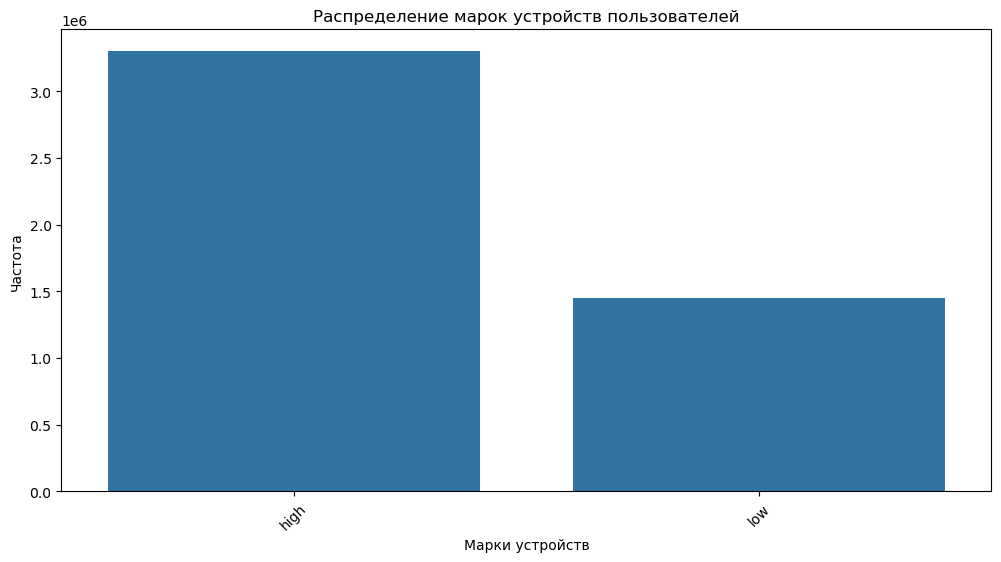

In [211]:
plot_countplot_device(data, 'device_brand_category')

## Из исследования мы видим, что соотношение марок устройств 50% в случае наиболее частых попаданий и наиболее редких марок в целом. Но для обучения модели, если марка телефона будет из категорированного списка, то это повысит ее обученность

# п.9 Провожу исследование колонки device_os
Ход исследования не меняется

In [35]:
data.device_os.value_counts

<bound method IndexOpsMixin.value_counts of 0              NaN
1              NaN
2          Android
3              NaN
4              NaN
            ...   
4743893        NaN
4743894        NaN
4743895    Windows
4743896        NaN
4743897        NaN
Name: device_os, Length: 4743898, dtype: object>

In [36]:
# Группируем по device_os и суммируем целевые значения
device_counts = data.groupby('device_os')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_deevice = device_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_deevice)

     device_os  target
1      Android    5940
12         iOS    2561
10     Windows    1105
6    Macintosh     800
5        Linux      95
0    (not set)       0
2   BlackBerry       0
3    Chrome OS       0
4   Firefox OS       0
7        Nokia       0


# Сводная таблица

| Колонка device_os | Количество вхождений целевой переменной | Новые переменные |
|---|:---|---|
| Android|5940|high|
| iOS|2561|high|
| Windows|1105|medium|
| Macintosh|800|medium|
| Linux|95|low|
| (not set)|0|high|
| BlackBerry|0|low|
| Chrome OS |0|low|
| Firefox OS|0|low|
| Nokia|0|low|
|  |  |  

## Из таблицы мы видим, что в основном количество заказов идут с телефонов, но есть и варианты с использованием компьютера

In [222]:
# Определяем функцию для присвоения категорий
def classify_device_os(device):
    high = ['Android','iOS']
    medium = ['Windows','Macintosh']
    
    if device in high:
        return 'high'
    elif device in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки device_os_category
data['device_os_category'] = data['device_os'].apply(classify_device_os)

In [223]:
# Определяем функцию для создания media_adcontents
def get_device_os(row):
    if (row['device_os_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки device_os_target
data['device_os_target'] = data.apply(get_device_os, axis=1)

## Для удобства создадим дополнительные колонки, что бы наша модель понимала что это за устройство

In [226]:
data['is_mobile'] = data.apply(lambda row: 1 if row['device_category'] == 'mobile' and row['target'] == 1 else 0, axis=1)
data['is_desktop'] = data.apply(lambda row: 1 if row['device_category'] == 'desktop' and row['target'] == 1 else 0, axis=1)
data['is_tablet'] = data.apply(lambda row: 1 if row['device_category'] == 'tablet' and row['target'] == 1 else 0, axis=1)

## Здесь я заменяю не интересующие нас переменные в одно значение и делаю замещение переменной (not set) в соответствии с условями, что бы понимать к чему отнести данные строки

In [228]:
def fill_device_os(row):
    # Заменяем значения на 'unknown'
    unknown_values = ['BlackBerry', 'Chrome OS', 'Tizen', 'Firefox OS', 'Nokia', 'Windows Phone', 'Linux', 'Samsung',]
    
    # Проверяем, нужно ли заменить значение на 'unknown'
    if row['device_os'] in unknown_values:
        return 'unknown'
    
    if row['device_os'] == '(not set)':
        # Определяем значение, основываясь на других колонках
        if row['device_category'] == 'mobile':
            if row['device_brand'] in ['Apple']:  # Для Apple - iOS
                return 'iOS'
            else:  # Другие мобильные бренды
                return 'Android'
        
        elif row['device_category'] == 'desktop':
            if row['device_screen_resolution'] == '1920x1080' or row['device_brand'] in ['Windows']:
                return 'Windows'
            else:  # Для Macintosh
                return 'Macintosh'
        
        elif row['device_category'] == 'tablet':
            if row['device_brand'] == 'Apple':  # Для Apple - iPad
                return 'iOS'
            else:  # У остальных планшетов на Android
                return 'Android'
        
        return 'unknown'  # Если значения не определены, возвращаем 'unknown'

    if pd.notnull(row['device_os']):
        return row['device_os']  # Если значение уже не пустое, возвращаем его

    return np.nan  # Если не подошло ни одно условие, возвращаем np.nan
data['device_os'] = data.apply(fill_device_os, axis=1)

In [229]:
# Замена NaN на 'unknown' в колонке utm_source
data['device_os'] = data['device_os'].fillna('unknown')

# Визуализирую данные

In [231]:
def plot_os_distribution_device(data, column='device_os_category', title='Распределение по операционным системам'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=20, kde=False)
    plt.title(title)
    plt.xlabel('Операционная система')
    plt.ylabel('Количество пользователей')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Визуализация

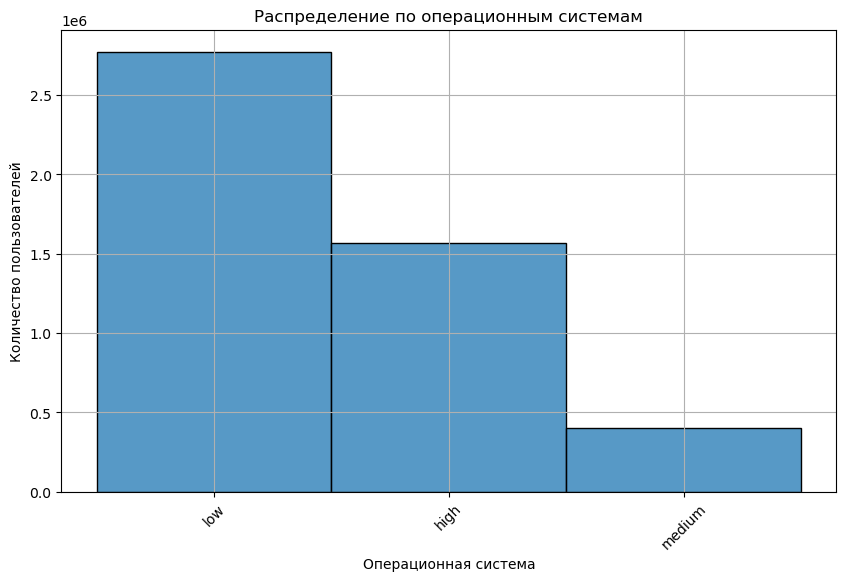

In [235]:
plot_os_distribution_device(data)

## Из данного исследования мы видим, что даже объединив наши результативные категории по объему наших переменных мы будем отставать от общего количества единиц, которые не совершили целевое действие, но для нашей модели будет полезно знать что вероятность совершения целевого действия, если это пользователь телефона, составляет около 30% и если это компьютер, то 6%

# п.10 Исследую колонку device_model

In [43]:
data.device_model.value_counts()

device_model
AuMdmADEIoPXiWpTsBEj    23780
tWBQlsvNfHxRUjaPAfhd     1273
pTgAEPipQxDXCjPrJbHo     1046
cwMJxNXiWUgMUxGiCTPs      947
tfPZFRbtlzEssBEesRwM      786
                        ...  
xMYlmvNxReLFGfXkQTYj        1
TMDlgkQzhHCgECHRtiOW        1
foPJGhraIZhogREKtYLR        1
aWSBcBZlKorTFjJGlWKG        1
vybTbTvsqxkeqykOdEPH        1
Name: count, Length: 95, dtype: int64

In [45]:
# Группируем по device_model и суммируем целевые значения
model_counts = data.groupby('device_model')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_model = model_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_model)

            device_model  target
1   AuMdmADEIoPXiWpTsBEj     131
51  bZGRDuESNKqbvzmxXlpf      10
82  tWBQlsvNfHxRUjaPAfhd       8
8   FJApgTrMAGHoxCxQVKws       8
76  pcvPxfVFaAmhwFmvIeYd       7
53  ciZAODXEPQGDKvuEabGr       5
52  bwQQjmDtGgrbnrREsYSG       5
75  pTgAEPipQxDXCjPrJbHo       4
6   DzXtLnggNbQSyyFLKlgY       3
7   EEnoZBXHUTLQhNvTLYel       3


In [52]:
data.drop(columns=['device_model'], inplace=True)

# Сводная таблица

| Колонка device_model| Количество вхождений целевой переменной |
|---|:---|
|AuMdmADEIoPXiWpTsBEj|131|
|bZGRDuESNKqbvzmxXlpf|10|
|tWBQlsvNfHxRUjaPAfhd|8|
|FJApgTrMAGHoxCxQVKws|8|
|pcvPxfVFaAmhwFmvIeYd|7|
|ciZAODXEPQGDKvuEabGr|5|
|bwQQjmDtGgrbnrREsYSG|5|
|pTgAEPipQxDXCjPrJbHo|4|
|DzXtLnggNbQSyyFLKlgY|3|
|EEnoZBXHUTLQhNvTLYel|3|
|  |  |  

## Наглядно мы видим, что для нашей модели и заказчика в целом данная колонка не несет никакого результата. Удаляем ее

# п.11 Исследую колонку hit_date
Колонка содержит информацию о датах совершения события, является классом объект, но мы поменяем формат и проведем исследование на отличие со смежной колонкой visit_date

In [87]:
data.hit_date.value_counts         

<bound method IndexOpsMixin.value_counts of 0          2021-09-12
1          2021-06-08
2          2021-12-11
3          2021-10-06
4          2021-06-11
              ...    
4743893    2021-08-16
4743894    2021-10-15
4743895    2021-12-19
4743896    2021-06-23
4743897    2021-06-06
Name: hit_date, Length: 4743898, dtype: object>

In [256]:
# Преобразуем столбцы в формат datetime
data['hit_date'] = pd.to_datetime(data['hit_date'])
data['visit_date'] = pd.to_datetime(data['visit_date'])

# Вывод минимальных и максимальных значений
min_hit_date = data['hit_date'].min()
max_hit_date = data['hit_date'].max()

min_visit_date = data['visit_date'].min()
max_visit_date = data['visit_date'].max()

print("Минимальная hit_date:", min_hit_date)
print("Максимальная hit_date:", max_hit_date)
print("Минимальная visit_date:", min_visit_date)
print("Максимальная visit_date:", max_visit_date)

# Сравнение диапазонов
if max_hit_date < min_visit_date:
    print("Диапазоны не пересекаются: hit_date до visit_date.")
elif max_visit_date < min_hit_date:
    print("Диапазоны не пересекаются: visit_date до hit_date.")
else:
    print("Диапазоны пересекаются.")

Минимальная hit_date: 2021-05-19 00:00:00
Максимальная hit_date: 2021-12-31 00:00:00
Минимальная visit_date: 2021-05-19 00:00:00
Максимальная visit_date: 2021-12-31 00:00:00
Диапазоны пересекаются.


## Данный образом мы проверили, что различий между данными нет, они корректны, но имеются NaN значения, которые мы можем легко заполнить благодаря visit_date

In [259]:
# Функция заполнения hit_date
def fill_hit_date(row):
    if pd.notnull(row['hit_date']):
        return row['hit_date']
    return row['visit_date']

# Применение функции
data['hit_date'] = data.apply(fill_hit_date, axis=1)

# Изменение hit_date к строке формата 'YYYY-MM-DD'
data['hit_date'] = data['hit_date'].dt.strftime('%Y-%m-%d')

# Визуализирую данные

In [261]:
def plot_cumulative_hits(data, column='hit_date', title='Кумулятивные посещения по датам'):
    cumulative_hits = data.groupby(column).size().cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_hits.index, cumulative_hits.values, marker='o')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Кумулятивные посещения')
    plt.grid()
    plt.show()

# Визуализация

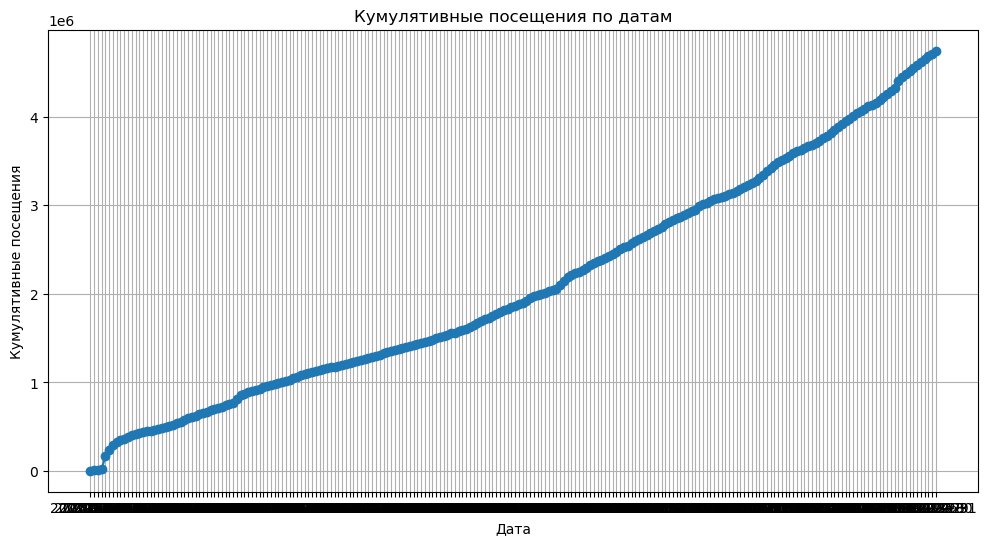

In [262]:
plot_cumulative_hits(data)

## По графику мы видим, что чем дольше работает наш ресурс тем на нем увеличивается посещаемость

# п.12 Исследую данные hit_time
В данном столбце мы наглядно видим присутствие NaN значений и что данные распределены неравномерно. Удалим выбросы и заполним отсутствующие значения средним

In [92]:
data.hit_time.value_counts 

<bound method IndexOpsMixin.value_counts of 0               NaN
1               NaN
2          218252.0
3               NaN
4               NaN
             ...   
4743893         NaN
4743894         NaN
4743895     72918.0
4743896         NaN
4743897         NaN
Name: hit_time, Length: 4743898, dtype: float64>

In [270]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = [q25 - 1.5 * iqr, q75 + 1.5 * iqr]
    return boundaries

# Вычисляем границы
boundaries = calculate_outliers(data['hit_time'])
max_hit_time = round(boundaries[1])

# Замена значений hit_time, превышающих max_hit_time
data.loc[data['hit_time'] > max_hit_time, 'hit_time'] = max_hit_time

In [272]:
# Вычисляем среднее значение
mean_value = data['hit_time'].mean()

# Заполняем пропуски средним значением без использования
data['hit_time'] = data['hit_time'].fillna(mean_value)

# Визуализирую данные

In [282]:
def plot_cumulative_time(data, column='hit_time', title='Кумулятивные посещения по времени'):
    cumulative_time = data.groupby(column).size().cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_time.index, cumulative_time.values, marker='o')
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Кумулятивные посещения')
    plt.grid()
    plt.show()

# Визуализация

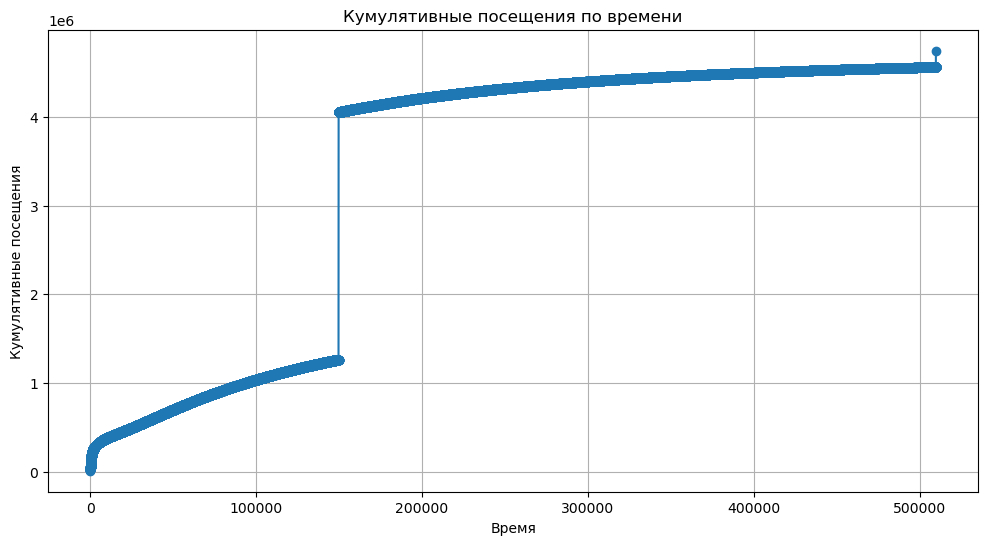

In [284]:
plot_cumulative_time(data)

## По данному графику мы явно видим зависимость между временем нахождения на сайте и количеством посещений ресурса

# п. 13 Исследую данные hit_number
Видим нулевые значения, меняем их на медиану

In [95]:
data.hit_number.value_counts    

<bound method IndexOpsMixin.value_counts of 0          37.0
1          26.0
2           7.0
3          22.0
4          12.0
           ... 
4743893    20.0
4743894    19.0
4743895    18.0
4743896    34.0
4743897    14.0
Name: hit_number, Length: 4743898, dtype: float64>

In [292]:
# Вычисляем медиану
hit_median_value = data['hit_number'].median()

# Заполняем пропуски медианой
data['hit_number'] = data['hit_number'].fillna(hit_median_value)

# Визуализирую данные

In [294]:
def plot_mean_target(data, hit_column='hit_number', target_column='target', 
                     title='Зависимость среднего значения target от hit_number'):
    mean_target = data.groupby(hit_column)[target_column].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(mean_target[hit_column], mean_target[target_column], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Номер события (hit_number)')
    plt.ylabel('Среднее значение target')
    plt.xticks(mean_target[hit_column])
    plt.grid()
    plt.show()

# Визуализация

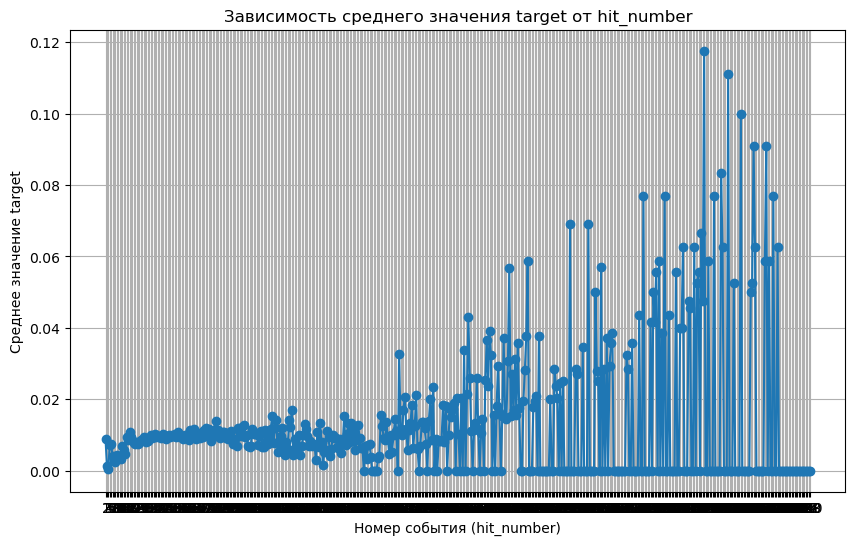

In [297]:
plot_mean_target(data)

In [19]:
table = data.pivot_table(index='hit_number', columns='target', aggfunc='size', fill_value=0)
print(table.to_markdown())

|   hit_number |      0 |    1 |
|-------------:|-------:|-----:|
|            1 |  30790 |  277 |
|            2 | 135705 |  180 |
|            3 | 329283 |  150 |
|            4 | 276399 | 1977 |
|            5 | 100196 |  749 |
|            6 | 122650 |  494 |
|            7 | 199916 |  539 |
|            8 | 170741 |  397 |
|            9 | 163145 |  724 |
|           10 | 156410 |  609 |
|           11 | 156281 |  640 |
|           12 | 157586 |  511 |
|           13 | 146570 | 1032 |
|           14 | 135783 |  793 |
|           15 | 169416 |  767 |
|           16 | 121551 | 1140 |
|           17 | 110167 |  944 |
|           18 |  98502 | 1063 |
|           19 |  92663 |  883 |
|           20 |  87642 |  752 |
|           21 |  84307 |  649 |
|           22 |  79852 |  601 |
|           23 |  75322 |  608 |
|           24 |  72152 |  536 |
|           25 |  68079 |  527 |
|           26 |  64052 |  556 |
|           27 |  59931 |  522 |
|           28 |  55791 |  530 |
|         

## т.к. из-за количества переменных target на heatmap и на графике визуально сложно определить зависимость я вывел таблицу, на которой видно в каких случаях доля положительных результатов увеличивается и какие значения hit_number мы можем определить как корректные

# п.14 Исследую данные hit_type
В данном случае колонка является неинформативной. Удаляю ее

In [97]:
data.hit_type.value_counts()

hit_type
event    4705456
Name: count, dtype: int64

In [98]:
data.drop(columns=['hit_type'], inplace=True)

# п.15 Исследую данные hit_referer

In [99]:
data.hit_referer.value_counts()

hit_referer
HbolMJUevblAbkHClEQa    2664645
FwdMTcXzWAwhtsnMAbhS      27475
sAGDBCdeVPmQPwkVEcIX      16060
GQmOLxANuSeCxCanBpMl      10695
ZeRnFrHdnMmnqraghdGJ       6799
                         ...   
nxoCvYUcQtVOtcmCJxvt          1
uCdzzMgzsxdZmtsmqdyu          1
zepLApHFsjpbaDiklmRb          1
FAKSWKVttJqmvIJcJBFE          1
JJbSvizJficzmgYcwKSg          1
Name: count, Length: 22026, dtype: int64

In [310]:
# Группируем по hit_referer и суммируем целевые значения
referer_counts = data.groupby('hit_referer')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_referer = referer_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_referer)

                hit_referer  target
3175   HbolMJUevblAbkHClEQa   19016
2502   FwdMTcXzWAwhtsnMAbhS     592
18603  sAGDBCdeVPmQPwkVEcIX     371
2653   GQmOLxANuSeCxCanBpMl     159
891    CENJYQocGncDfpQMoNnT     106
5852   NfSAiKHBqffzsXrbjcSr      48
11557  ayiFomhbZsohffvJEYjc      40
10955  ZeRnFrHdnMmnqraghdGJ      37
12809  eAbATQERmGPolIKkWXkU      37
11761  bXJEDJDDLCUCnbivDkAt      35


In [312]:
# Определяем функцию для присвоения категорий
def classify_referer(referer):
    high = ['HbolMJUevblAbkHClEQa']
    if referer in high:
        return 'high'    
    else:
        return 'low'

# Применяем функцию для создания новой колонки referer_category
data['referer_category'] = data['hit_referer'].apply(classify_referer)

In [314]:
# Определяем функцию для создания referer_target
def get_referer(row):
    if (row['referer_category'] in ['high']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки referer_target
data['referer_target'] = data.apply(get_referer, axis=1)

In [315]:
data.loc[data['referer_target'] == 0, 'hit_referer'] = 'unknown'

# Сводна таблица

| Колонка hit_referer  | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|HbolMJUevblAbkHClEQa|19016|high
|FwdMTcXzWAwhtsnMAbhS|592|low
|sAGDBCdeVPmQPwkVEcIX|371|low
|GQmOLxANuSeCxCanBpMl|159|low
|CENJYQocGncDfpQMoNnT|106|low
|NfSAiKHBqffzsXrbjcSr|48|low
|ayiFomhbZsohffvJEYjc|40|low
|ZeRnFrHdnMmnqraghdGJ|37|low
|eAbATQERmGPolIKkWXkU|37|low
|bXJEDJDDLCUCnbivDkAt|35|low
|  |  |  

# Визуализирую данные

In [320]:
def plot_pie_chart_referer(data, column, title='Распределение источников событий'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

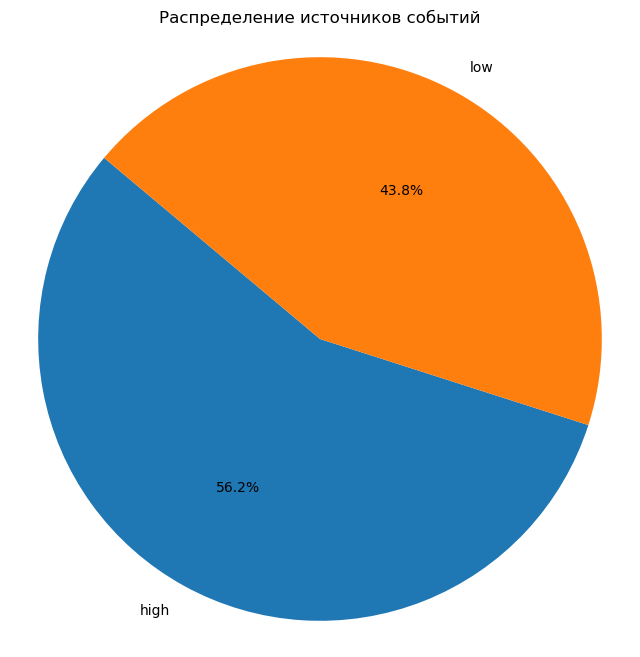

In [322]:
plot_pie_chart_referer(data, 'referer_category')

## Мы видим, что лишь один источник события несет в себе целевое действие в размере 62% от общего количества благоприятных исходов, доля его в выборке равна 56.2%. Использование его в моделе будет значительно помогать в составлении благоприятных условий

# п.16 Исследую данные hit_page_path
В этом разделе я составил словарь встречающихся в переменных названий марок и моделей машин для нескольких целей. \
Во первых: можно понять рентабельность моделей и какие модели чаще берут, это будет полезно нашему клиенту. \
Во вторых: если отправить данную строку модели, то это повысит количество благоприятных исходов. \
Ввиду того, что мне не хватило ресурсов на этот метод я оставил его работоспособным, но для обучения не использовал.

In [104]:
data.hit_page_path.value_counts

<bound method IndexOpsMixin.value_counts of 0                                     podpiska.sberauto.com/
1          sberauto.com/cars/7a3f9330?rental_page=rental_car
2          sberauto.com/cars?utm_source_initial=sbol&utm_...
3          sberauto.com/cars/all/hyundai/solaris/6afb1543...
4          sberauto.com/cars?city=1&rental_page=rental_on...
                                 ...                        
4743893                               podpiska.sberauto.com/
4743894    sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...
4743895    sberauto.com/cars/all/renault/logan/8c3c73f2?r...
4743896    sberauto.com/cars/bf24b977?rental_page=rental_car
4743897    sberauto.com/cars/94b3d18e?rental_page=rental_car
Name: hit_page_path, Length: 4743898, dtype: object>

In [105]:
# Словарь известных брендов и соответствующих им моделей
car_data = {
    'toyota': ['camry', 'corolla', 'rav4'],
    'honda': ['accord', 'civic', 'cr-v'],
    'ford': ['focus', 'fiesta', 'mustang'],
    'bmw': ['x3', 'x5', '3-series','2-serii'],
    'mercedes-benz': ['a-class', 'c-class', 'e-class', 's-class'],
    'skoda': ['rapid, karoq','oktavia'],
    'volkswagen' : ['polo', 'tiguan', 'touareg'],
    'lada': ['vesta'],
    'renault': ['logan'],
    'nissan' : ['qashqai', 'x-trail'],
    'porsche' : ['cayenne'],
    'kia' : ['sorento']
}

# Функция для извлечения марки и модели из строки
def extract_car_details(text):
    if pd.isna(text):  # Проверяем, является ли значение NaN
        return None, None
    
    text = text.lower()  # Преобразуем текст к нижнему регистру
    brand_found = None
    model_found = None

    # Поиск брендов
    for brand in car_data.keys():
        if brand in text:
            brand_found = brand
            # Поиск моделей для найденного бренда
            for model in car_data[brand]:
                if model in text:
                    model_found = model
                    break  # Найдена первая модель, можем прекратить поиск
            break  # Найден бренд, можем прервать проверку

    return brand_found, model_found

# Применяем функцию к столбцу hit_page_path
data['car_brand'], data['car_model'] = zip(*data['hit_page_path'].apply(extract_car_details))

In [106]:
# Подсчет количества значений для каждой марки
brand_counts = data['car_brand'].value_counts()
brand_counts

car_brand
skoda            221960
mercedes-benz    140807
volkswagen       123212
lada             120570
nissan           109203
bmw               82094
kia               72517
toyota            49278
renault           44637
porsche           18815
ford                135
honda               131
Name: count, dtype: int64

In [107]:
model_counts = data['car_model'].value_counts()
model_counts

car_model
vesta      119620
polo        93484
qashqai     45242
x-trail     25054
camry       22146
logan       21286
sorento     20450
tiguan      18374
cayenne     11567
x3           8664
x5           8376
corolla      7115
2-serii      6738
touareg      5544
civic          22
cr-v           22
focus          19
accord          8
mustang         3
Name: count, dtype: int64

In [108]:
# Группируем по car_brand и суммируем целевые значения
car_brand_counts = data.groupby('car_brand')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_car_brand = car_brand_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_car_brand)

        car_brand  target
9           skoda    2325
4            lada    1578
11     volkswagen    1454
3             kia     814
5   mercedes-benz     699
10         toyota     473
0             bmw     431
8         renault     402
6          nissan     367
7         porsche      39


In [109]:
# Определяем функцию для присвоения категорий
def classify_car_brand(car_brand):
    high = ['skoda']
    medium = ['lada', 'volkswagen']
    if car_brand in high:
        return 'high'  
    if car_brand in medium:
        return 'medium' 
    else:
        return 'low'

# Применяем функцию для создания новой колонки referer_category
data['car_brand_category'] = data['car_brand'].apply(classify_car_brand)

In [110]:
# Определяем функцию для создания car_brand_target
def get_car_brand_target(row):
    if (row['car_brand_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки car_brand_target
data['car_brand_target'] = data.apply(get_car_brand_target, axis=1)

In [111]:
# Группируем по car_model и суммируем целевые значения
car_model_counts = data.groupby('car_model')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_car_model = car_model_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_car_model)

   car_model  target
15     vesta    1577
10      polo    1338
2      camry     320
8      logan     274
11   qashqai     227
12   sorento     162
16   x-trail     140
13    tiguan      88
18        x5      78
5    corolla      56


In [112]:
# Определяем функцию для присвоения категорий
def classify_car_model(car_model):
    high = ['vesta']
    medium = ['polo']
    if car_model in high:
        return 'high'  
    if car_model in medium:
        return 'medium' 
    else:
        return 'low'

# Применяем функцию для создания новой колонки referer_category
data['car_model_category'] = data['car_model'].apply(classify_car_model)

In [113]:
# Определяем функцию для создания car_brand_target
def get_car_model_target(row):
    if (row['car_brand_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки car_model_target
data['car_model_target'] = data.apply(get_car_model_target, axis=1)

In [114]:
# Функция для замены значений в hit_page_path
def replace_informative_paths(row):
    if row['car_brand_target'] == 1 or row['car_model_target'] == 1:
        return row['hit_page_path']  # Оставляем информативный путь
    else:
        return 'unknown'  # Заменяем на unknown

# Применяем функцию к каждой строке
data['hit_page_path'] = data.apply(replace_informative_paths, axis=1)

In [115]:
# Условие для совпадений по марке и модели с учетом target
matches_brand = data[(data['car_brand'] == data['target']) | (data['target'] == 1)]
mismatches_brand = data[~((data['car_brand'] == data['target']) | (data['target'] == 1))]
matches_model = data[(data['car_model'] == data['target']) | (data['target'] == 1)]
mismatches_model = data[~((data['car_model'] == data['target']) | (data['target'] == 1))]

# Количество совпадений и несовпадений
num_matches_model = matches_model.shape[0]
num_mismatches_model = mismatches_model.shape[0]
num_matches_brand = matches_brand.shape[0]
num_mismatches_brand = mismatches_brand.shape[0]

# Вывод результатов
print(f'Количество совпадений по модели: {num_matches_model}')
print(f'Количество несовпадений по модели: {num_mismatches_model}')
print(f'Количество совпадений по марке: {num_matches_brand}')
print(f'Количество несовпадений по марке: {num_mismatches_brand}')

Количество совпадений по модели: 30643
Количество несовпадений по модели: 4713255
Количество совпадений по марке: 30643
Количество несовпадений по марке: 4713255


In [116]:
# Замена NaN на 'unknown' в колонке car_brand
data['car_brand'] = data['car_brand'].fillna('unknown')

In [117]:
# Замена NaN на 'unknown' в колонке car_model
data['car_model'] = data['car_model'].fillna('unknown')

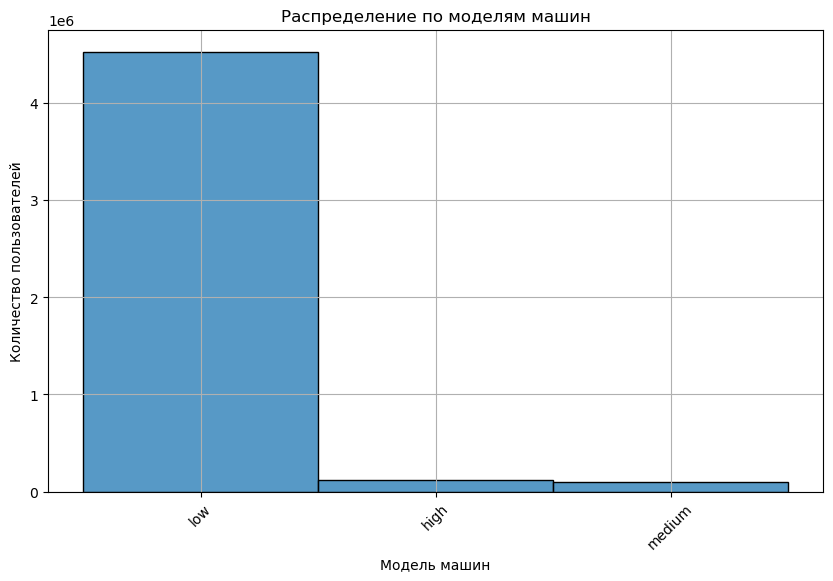

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(data['car_model_category'], bins=20, kde=False)
plt.title('Распределение по моделям машин')
plt.xlabel('Модель машин')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid()
plt.show()

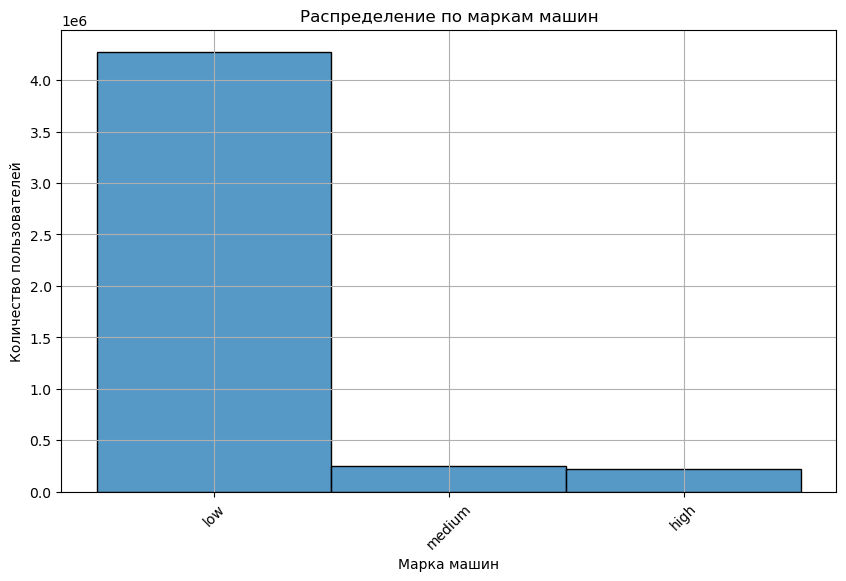

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(data['car_brand_category'], bins=20, kde=False)
plt.title('Распределение по маркам машин')
plt.xlabel('Марка машин')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid()
plt.show()

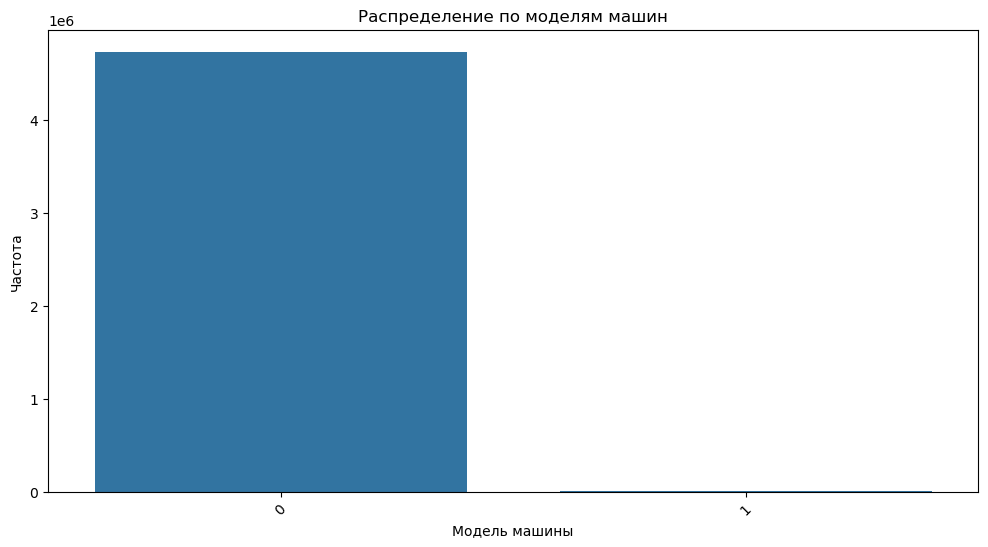

In [107]:
# Создание графика
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='car_model_target', order=data['car_model_target'].value_counts().index)

plt.title('Распределение по моделям машин')
plt.xticks(rotation=45)
plt.xlabel('Модель машины')
plt.ylabel('Частота')
plt.show()

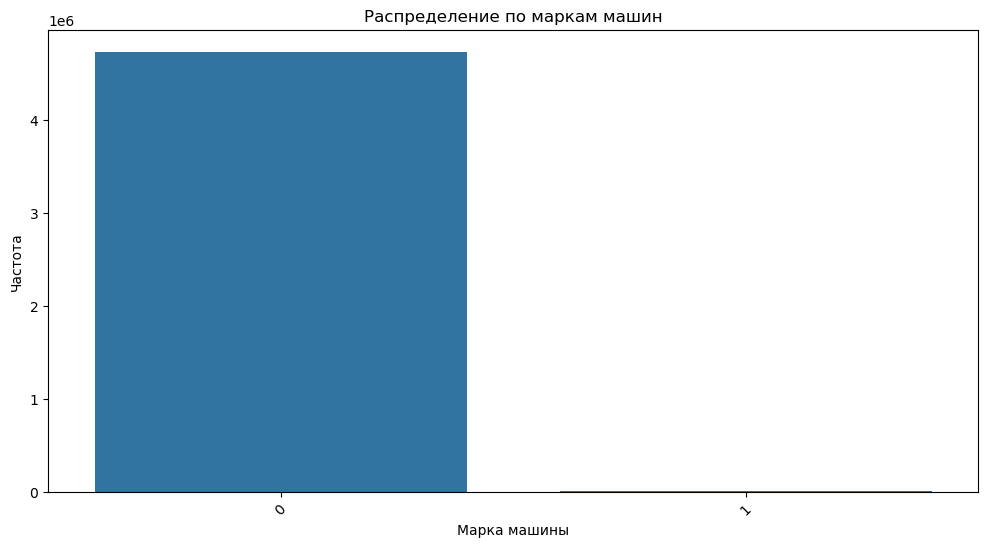

In [111]:
# Создание графика
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, x='car_brand_target', order=data['car_model_target'].value_counts().index)

plt.title('Распределение по маркам машин')
plt.xticks(rotation=45)
plt.xlabel('Марка машины')
plt.ylabel('Частота')
plt.show()

In [402]:
data.drop(columns=['hit_page_path'], inplace=True)

In [403]:
data.drop(columns=['car_brand'], inplace=True)

In [404]:
data.drop(columns=['car_model'], inplace=True)

In [405]:
data.drop(columns=['car_brand_category'], inplace=True)

In [410]:
data.drop(columns=['car_model_category'], inplace=True)

In [412]:
data.drop(columns=['car_model_target'], inplace=True)

In [413]:
data.drop(columns=['car_brand_target'], inplace=True)

# п.17 Исследую данные event_category

In [118]:
data.event_category.value_counts()

event_category
card_web                         2230054
search_form                       724862
sub_page_view                     596585
sub_button_click                  320996
listing_ads                       311269
cars                              107654
sap_search_form                   106825
quiz                               78750
sap_search__form                   56745
auth                               55666
jivosite                           26518
chat                               25597
ad_banner                          11951
offers                              9362
navigation                          7963
footer                              6052
sub_submit                          5338
greenday_sub_button_click           4598
main_banners                        4100
profile_menu                        4046
scrolling_main_page                 3598
active_invitation                   2563
header                              1047
my_idea                              701
g

In [119]:
# Группируем по event_category и суммируем целевые значения
event_category_counts = data.groupby('event_category')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_event = event_category_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_event)

         event_category  target
46     sub_button_click   25318
48           sub_submit    5325
0     active_invitation       0
38                phone       0
28  greenday_sub_submit       0
29               header       0
30             jivosite       0
31          listing_ads       0
32      main_advantages       0
33         main_banners       0


In [332]:
# Определяем функцию для присвоения категорий
def classify_event(event):
    high = ['sub_button_click']
    medium = ['sub_submit']
    if event in high:
        return 'high' 
    if event in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки event_category_target
data['event_category_classify'] = data['event_category'].apply(classify_event)

In [333]:
# Определяем функцию для создания event_category_target
def get_event_category(row):
    if (row['event_category_classify'] in ['high','medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки event_category_target
data['event_category_target'] = data.apply(get_event_category, axis=1)

In [334]:
data.loc[data['event_category_target'] == 0, 'event_category'] = 'unknown'

# Сводная таблица

| Колонка event_category| Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|sub_button_click|25318|high
|sub_submit|5325|medium
|active_invitation|0|low
|phone|0|low
|greenday_sub_submit|0|low
|header|0|low
|jivosite|0|low
|listing_ads|0|low
|main_advantages|0|low
|main_banners|0|low
|  |  |  

# Визуализирую данные

In [340]:
def plot_pie_chart_category(data, column, title='Распределение типов действий'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

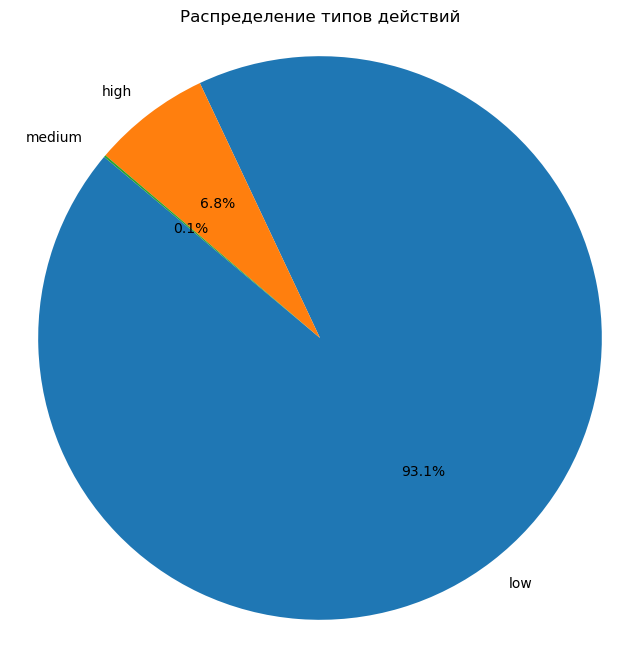

In [342]:
plot_pie_chart_category(data, 'event_category_classify')

## Как мы видим, общая выборка состоит из переменных, которые нам не интересны, но наши выделенные категории напрямую относятся к переменной target и составляют 100% общего числа благоприятных условий

# п. 18 Исследую данные event_label

In [123]:
data.event_label.value_counts()

event_label
KclpemfoHstknWHFiLit    1952589
hAHqGICPFQiPwtzubOzs     384376
OHfyUfDKdPgBdvelDlfG     187894
pzAKUYdRKNEUXxxBFUPX     107654
ghOrjqpgskpGHSFfBBsi     102852
                         ...   
XJetmBDDTFrrMCenaPoR          1
GAJNwxAgLORIYHrUOQPG          1
JGyGaSBfxDfwypydkjNf          1
BOCwktGurWmQxMvlXESi          1
NkHVtgvnntbFyNyUbLFX          1
Name: count, Length: 18723, dtype: int64

In [124]:
# Группируем по event_label и суммируем целевые значения
event_label_counts = data.groupby('event_label')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_label = event_label_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_label)

                event_label  target
1737   EsLbNNEnCkXWoaesnKlS   10461
1373   DrwJcHfmgRDbfayCKOrQ    4126
3844   KclpemfoHstknWHFiLit    3943
14368  nsPPIRqjxBefONGPpnsF    3493
9227   ZaZuwAXOKlbzyhUqtnmk    2028
3964   KuMiABMMbspIDDhiCNVS    1694
16795  uimgZZmhfLQwbKAZZfCk     850
14414  nzDXtAvtTrzfwscIPQkp     780
18328  yrNVHowDbZsxjfjrrhyG     676
9220   ZZofswPTYfyzKOvStgaa      21


In [348]:
# Определяем функцию для присвоения категорий
def classify_label(label):
    high = ['EsLbNNEnCkXWoaesnKlS']
    medium = ['DrwJcHfmgRDbfayCKOrQ','KclpemfoHstknWHFiLit','nsPPIRqjxBefONGPpnsF','ZaZuwAXOKlbzyhUqtnmk','KuMiABMMbspIDDhiCNVS']
    if label in high:
        return 'high' 
    if label in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки event_label_classify
data['event_label_classify'] = data['event_label'].apply(classify_label)

In [350]:
# Определяем функцию для создания event_label_category_target
def get_event_label_category(row):
    if (row['event_label_classify'] in ['high','medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки event_label_category_target
data['event_label_category_target'] = data.apply(get_event_label_category, axis=1)

In [351]:
data.loc[data['event_label_category_target'] == 0, 'event_label'] = 'unknown'

# Сводная таблица

| Колонка event_label | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|EsLbNNEnCkXWoaesnKlS|10461|high
|DrwJcHfmgRDbfayCKOrQ|4126|medium
|KclpemfoHstknWHFiLit|3943|medium
|nsPPIRqjxBefONGPpnsF|3493|medium
|ZaZuwAXOKlbzyhUqtnmk|2028|medium
|KuMiABMMbspIDDhiCNVS|1694|medium
|uimgZZmhfLQwbKAZZfCk|850|low
|nzDXtAvtTrzfwscIPQkp|780|low
|yrNVHowDbZsxjfjrrhyG|676|low
|ZZofswPTYfyzKOvStgaa|21|low
|  |  |  

# Визуализирую данные

In [354]:
def plot_os_distribution_event(data, column='event_label_classify', title='Распределение тегов действия'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=20, kde=False)
    plt.title(title)
    plt.xlabel('Тег')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Визуализация

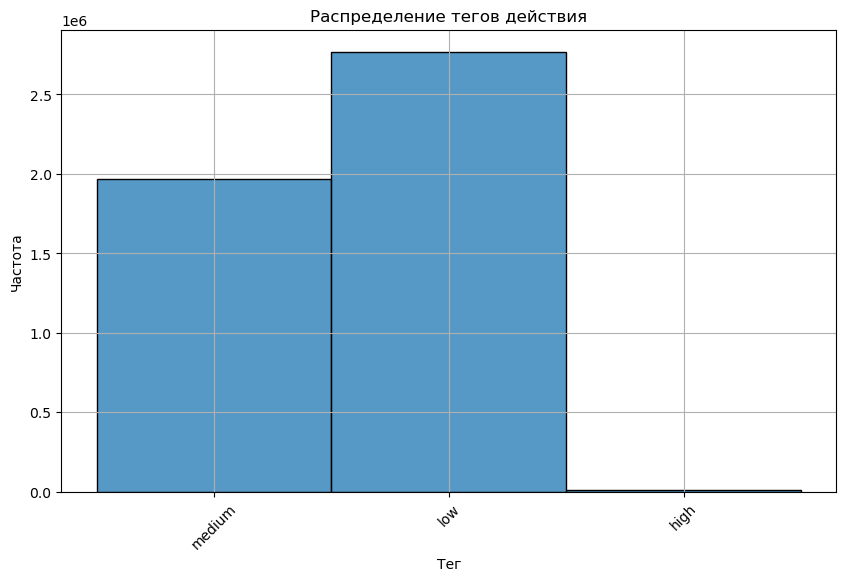

In [358]:
plot_os_distribution_event(data)

## По визуализации видим, что общая составляющая колонок с интересом для нас составляют наименьшее количество общих значений, но для нашей модели будет актуальны эти значения в целях обучения

# п. 19 Изучаю данные event_value
Значений в данной колонке нет, мы ее удаляем

In [128]:
data.event_value.value_counts()

Series([], Name: count, dtype: int64)

In [129]:
data.drop(columns=['event_value'], inplace=True)

# п.20 Повторно используем метод поиска по NaN
В данном датасете отсутствую такие значения

In [130]:
na_count = data.isna().sum()
na_with_values = na_count[na_count > 0]
print(na_with_values)

Series([], dtype: int64)


# Выведем список колонок

In [131]:
data.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'hit_date', 'hit_time', 'hit_number', 'hit_referer', 'hit_page_path',
       'event_category', 'event_action', 'event_label', 'target',
       'utm_source_classification', 'source_target', 'media_company',
       'media_target', 'media_adcontents', 'media_adcontents_target',
       'media_keyword', 'media_keyword_target', 'device_brand_category',
       'device_brand_target', 'device_os_category', 'device_os_target',
       'is_mobile', 'is_desktop', 'is_tablet', 'referer_category',
       'referer_target', 'car_brand', 'car_model', 'car_brand_category',
       'car_brand_target', 'car_model_category', 'car_model_target',
       'event_category_classify', 'event_category_target',
       '

# Сводная таблица

| Название колонки | Отметка об обработке | Состояние колонки
|---|:---|---|
|session_id|
|client_id|
|visit_date|
|visit_time|
|visit_number|
|utm_source|+| Строки категорированы
|utm_medium|
|utm_campaign|+| Строки категорированы
|utm_adcontent|+| Строки категорированы
|utm_keyword|+| Строки категорированы
|device_category|
|device_os|+| Строки категорированы
|device_brand|+| Строки категорированы
|device_model|-| Удалено
|device_screen_resolution|
|device_browser|
|geo_country|
|geo_city|
|hit_date|+| Строки проверены
|hit_time|+| Строки проверены, выбросы удалены
|hit_number|+| Строки проверены, заменены медианой
|hit_type|-| Удалено
|hit_referer|+| Строки категорированы
|hit_page_path|-| Удалено
|event_category|+| Строки категорированы
|event_action|+| Строки категорированы
|event_label|+| Строки категорированы
|event_value|-| Удалено
|target|+| Строки категорированы
|utm_source_classification|+| Строки категорированы
|source_target|+| Строки категорированы
|media_company|+| Строки категорированы
|media_target|+| Строки категорированы
|media_adcontents|+| Строки категорированы
|media_adcontents_target|+| Строки категорированы
|media_keyword|+| Строки категорированы
|media_keyword_target|+| Строки категорированы
|device_brand_category|+| Строки категорированы
|device_brand_target|+| Строки категорированы
|device_os_category|+| Строки категорированы
|device_os_target|+| Строки категорированы
|is_mobile|+| Строки категорированы
|is_desktop|+| Строки категорированы
|is_tablet|+| Строки категорированы
|referer_category|+| Строки категорированы
|referer_target|+| Строки категорированы
|car_brand|-| Удалено
|car_model|-| Удалено
|car_brand_category|-| Удалено
|car_brand_target|-| Удалено
|car_model_category|-| Удалено
|car_model_target|-| Удалено
|event_category_classify|+| Строки категорированы
|event_category_target|+| Строки категорированы
|event_label_classify|+| Строки категорированы
|event_label_category_target|+| Строки категорированы
|  |  |  

# п.21 Исследую данные session_id
Проверил строки на отличные значения от типовых, проверил на NaN, подобных случаев не выявлено

In [132]:
data.session_id.value_counts

<bound method IndexOpsMixin.value_counts of 0          1373451038752661866.1631478122.1631478122
1          3860854435957650478.1623143469.1623143469
2          2683266182562265160.1639214789.1639214789
3          3841366739121903174.1633503222.1633503222
4          8057441511723475183.1623433455.1623433455
                             ...                    
4743893    7059104680493360594.1629136337.1629136337
4743894    7908976840342618848.1634321123.1634321123
4743895    1953231336916799142.1639910394.1639910394
4743896    9064907880063502877.1624443421.1624443421
4743897    7673090050954640093.1622948575.1622948575
Name: session_id, Length: 4743898, dtype: object>

In [133]:
# Функция для проверки на одинаковость значений в строке
def check_same_values(row):
    # Разделить строку по разделителю (в данном случае - точка)
    split_values = row.split('.')
    # Проверка на уникальность с учетом NaN
    return len(set(split_values)) == 1

# Применение функции к DataFrame
same_value_rows = data[data['session_id'].apply(check_same_values)]

print(same_value_rows)

Empty DataFrame
Columns: [session_id, client_id, visit_date, visit_time, visit_number, utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword, device_category, device_os, device_brand, device_screen_resolution, device_browser, geo_country, geo_city, hit_date, hit_time, hit_number, hit_referer, hit_page_path, event_category, event_action, event_label, target, utm_source_classification, source_target, media_company, media_target, media_adcontents, media_adcontents_target, media_keyword, media_keyword_target, device_brand_category, device_brand_target, device_os_category, device_os_target, is_mobile, is_desktop, is_tablet, referer_category, referer_target, car_brand, car_model, car_brand_category, car_brand_target, car_model_category, car_model_target, event_category_classify, event_category_target, event_label_classify, event_label_category_target]
Index: []

[0 rows x 53 columns]


# п. 22 Исследую данные client_id
Создал дополнительный датафрейм для сравнения схождений со смежной колонкой. Данные не подтвердились, следовательно, для снижения нагрузки на обучение модели данную колонку я убираю.

In [134]:
data.client_id.value_counts

<bound method IndexOpsMixin.value_counts of 0           319781489.1631478122
1           898925223.1623143470
2           624746592.1634809928
3           894387890.1633457734
4          1876019293.1623433455
                   ...          
4743893    1643575886.1629136338
4743894    1841452168.1634321120
4743895     454772109.1628851878
4743896    2110588336.1624443421
4743897    1786530495.1622948573
Name: client_id, Length: 4743898, dtype: object>

In [135]:
# Подсчет количества визитов для каждого клиента
visit_counts = data.groupby('client_id')['session_id'].nunique().reset_index()
visit_counts.columns = ['client_id', 'visit_count']
visit_counts

client_id  visit_count
0                      1000000719.1634385152            1
1                        10000026.1621927845            1
2                      1000002812.1632654122            2
3                      1000005466.1623263709            1
4                      1000013395.1633830746            1
...                                      ...          ...
949422                  999992480.1626355201            1
949423                  999993469.1624255512            1
949424                  999995462.1631174885            1
949425                  999998921.1631657636            2
949426  d90a77b7-a1e7-46b7-8d1d-29c452849d1d            1

[949427 rows x 2 columns]

In [136]:
merged_data = pd.concat([data['visit_number'], visit_counts['visit_count']], axis=1)

# 3. Сравнение колонок
# Проверяем, где значения не совпадают
mismatches = merged_data[merged_data['visit_number'] != merged_data['visit_count']]
matches = merged_data[merged_data['visit_number'] == merged_data['visit_count']]

# 4. Выводим количество несовпадений
num_mismatches = mismatches.shape[0]
num_matches = matches.shape[0]
print(f'Количество совпадений: {num_matches}')
print(f'Количество несовпадений: {num_mismatches}')

Количество совпадений: 614672
Количество несовпадений: 4129226


In [137]:
data.drop(columns=['client_id'], inplace=True)

# п. 23 Исследую колонку visit_date

In [138]:
data.visit_date.value_counts

<bound method IndexOpsMixin.value_counts of 0         2021-09-12
1         2021-06-08
2         2021-12-11
3         2021-10-06
4         2021-06-11
             ...    
4743893   2021-08-16
4743894   2021-10-15
4743895   2021-12-19
4743896   2021-06-23
4743897   2021-06-06
Name: visit_date, Length: 4743898, dtype: datetime64[ns]>

# Визуализирую данные

In [382]:
def plot_cumulative_date(data, column='visit_date', title='Кумулятивные посещения по датам'):
    cumulative_time = data.groupby(column).size().cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_time.index, cumulative_time.values, marker='o')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Кумулятивные посещения')
    plt.grid()
    plt.show()

# Визуализация

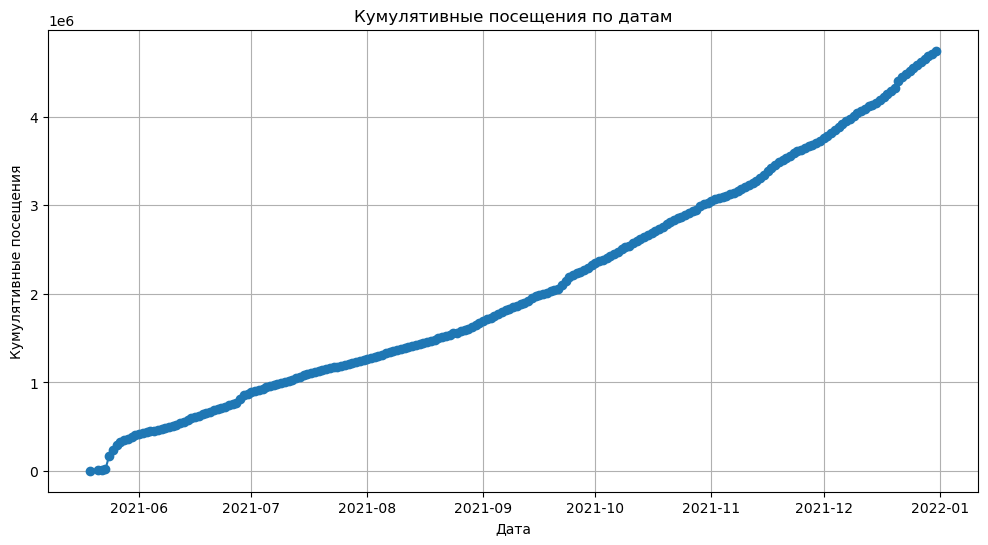

In [386]:
plot_cumulative_date(data)

## По графику мы видим, что с течением времени посещаемость ресурса увеличивается

# п. 24 Исследую колонку visit_time
Создаем дополнительные колонки с обозначением дня недели и времени, когда осуществлялись заходы на ресурс

In [147]:
data.visit_time.value_counts

<bound method IndexOpsMixin.value_counts of 0          23:00:00
1          12:00:00
2          12:26:29
3          09:00:00
4          20:00:00
             ...   
4743893    20:00:00
4743894    21:00:00
4743895    13:39:54
4743896    13:00:00
4743897    06:00:00
Name: visit_time, Length: 4743898, dtype: object>

In [391]:
# Извлечение дня недели и времени суток
data['day_of_week'] = data['visit_date'].dt.dayofweek
data['hour_of_day'] = data['visit_time'].apply(lambda x: int(x.split(':')[0]))

In [397]:
# Создаем представление с днем недели и количеством вхождений целевой переменной target
summary = data.groupby('day_of_week')['target'].sum().reset_index()

# Переименовываем столбцы для удобства
summary.columns = ['day_of_week', 'target']

# Для удобства считывания, добавляем наименования дней недели
summary['day_of_week'] = summary['day_of_week'].replace({
    0: 'Понедельник', 
    1: 'Вторник', 
    2: 'Среда', 
    3: 'Четверг', 
    4: 'Пятница', 
    5: 'Суббота', 
    6: 'Воскресенье'
})

# Сортируем по дням недели
summary['day_of_week'] = pd.Categorical(summary['day_of_week'], 
                                         categories=['Понедельник', 'Вторник', 'Среда', 
                                                     'Четверг', 'Пятница', 
                                                     'Суббота', 'Воскресенье'], 
                                         ordered=True)

summary = summary.sort_values('day_of_week')

# Выводим результат
print(summary)

   day_of_week  target
0  Понедельник    5379
1      Вторник    5614
2        Среда    4590
3      Четверг    4649
4      Пятница    3901
5      Суббота    3342
6  Воскресенье    3168


# Визуализирую данные

In [395]:
def plot_countplot_week(data, x_col, title='Количество вхождений целевой переменной по дням недели', xlabel='День недели', ylabel='Количество вхождений target'):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Визуализация

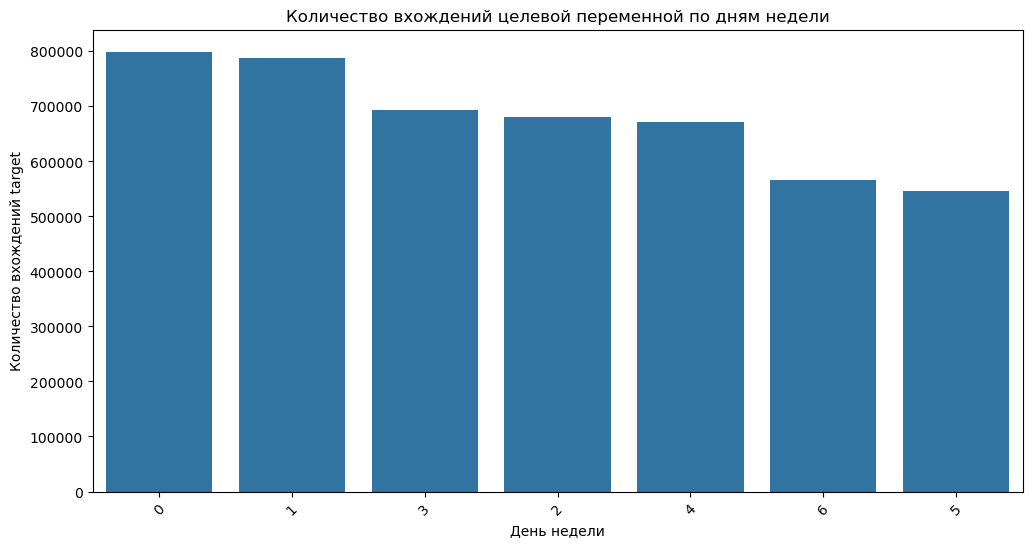

In [401]:
plot_countplot_week(data, 'day_of_week')

## Так как в первые дни недели наибольшая востребованность в нашем ресурсе, то выделим эти два дня в отдельные колонки

In [154]:
# Создание колонки is_monday
data['is_monday'] = ((data['day_of_week'] == 0) & (data['target'] == 1)).astype(int)
# Создание колонки is_tuesday
data['is_tuesday'] = ((data['day_of_week'] == 1) & (data['target'] == 1)).astype(int)

# Визуализация данных

In [407]:
def plot_average_target_by_hour(data, hour_column='hour_of_day', target_column='target', 
                                 title='Зависимость между часом дня и целевой переменной'):
    # Создание сводной таблицы для подсчета среднего значения и количества целевой переменной
    pivot_table = data.pivot_table(index=hour_column, values=target_column, aggfunc='mean').reset_index()
    pivot_table['target_count'] = data.groupby(hour_column)[target_column].count().values
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=hour_column, y=target_column, data=pivot_table)
    plt.title(title)
    plt.xlabel('Час дня')
    plt.ylabel('Среднее значение target')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')
    plt.show()

# Визуализация

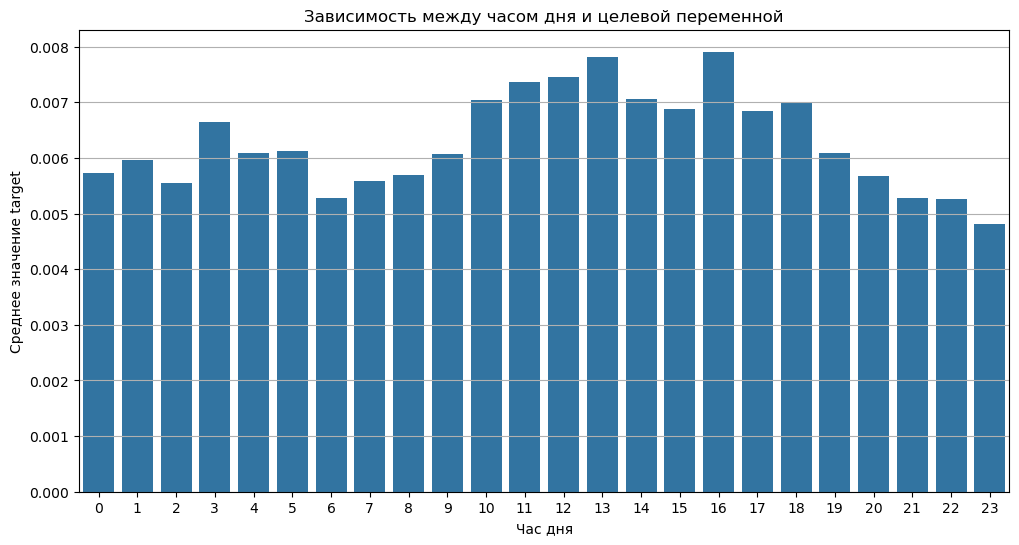

In [409]:
plot_average_target_by_hour(data)

# Так, как наибольший трафик приходится на числа от 10 до 18 часов выделим это отдельной категорией

In [156]:
# Создание колонки is_traffic_time
data['is_traffic_time'] = ((data['hour_of_day'] >= 10) & (data['hour_of_day'] <= 18) & (data['target'] == 1)).astype(int)

# п.25 Исследую данные visit_number
Убираю в значениях выбросы, дальнейшее исследование без изменений

In [157]:
data.visit_number.value_counts

<bound method IndexOpsMixin.value_counts of 0           1
1           1
2           2
3           2
4           1
           ..
4743893     1
4743894     1
4743895    80
4743896     1
4743897     1
Name: visit_number, Length: 4743898, dtype: int64>

In [412]:
boundaries = calculate_outliers(data['visit_number'])
max_visit_number = round(boundaries[1])


# Замена значений visit_number, превышающих max_visit_number
data.loc[data['visit_number'] > max_visit_number, 'visit_number'] = max_visit_number

In [160]:
# Подсчитываем количество уникальных визитов для каждой сессии
visits_count = data.groupby('session_id')['visit_number'].max().reset_index()

# Переименуем колонку
visits_count.columns = ['session_id', 'visits_groups']

# Объединяем с исходным DataFrame
data = pd.merge(data, visits_count, on='session_id')

# Функция для категоризации визитов
def categorize_visits(visits_groups):
    if visits_groups == 1:
        return 'low'
    elif visits_groups == 2:
        return 'medium'
    elif visits_groups == 3:
        return 'high'
    elif visits_groups >= 4:
        return 'expert' 
    else:
        return 'unknown'

# Создаем новый столбец с категориями
data['visit_category'] = data['visits_groups'].apply(categorize_visits)

In [161]:
# Определяем функцию для создания media_adcontents
def get_visit_category(row):
    if (row['visit_category'] in ['expert''high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки media_adcontents_target
data['visit_category_target'] = data.apply(get_visit_category, axis=1)

In [162]:
data.drop(columns=['visits_groups'], inplace=True)

# Визуализирую данные

In [414]:
def plot_average_target_by_visit(data, visit_column='visit_number', target_column='target', 
                                  title='Зависимость вероятности целевого действия от номера визита'):
    # Группировка данных по номеру визита и вычисление среднего значения целевой переменной
    grouped_number = data.groupby(visit_column, as_index=False)[target_column].mean()
    
    # Визуализация зависимости
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_number[visit_column], grouped_number[target_column], marker='o')
    plt.title(title)
    plt.xlabel('Номер визита')
    plt.ylabel('Среднее значение target')
    plt.xticks(grouped_number[visit_column])  # Отображение всех значений visit_number
    plt.grid()
    plt.show()

# Визуализация

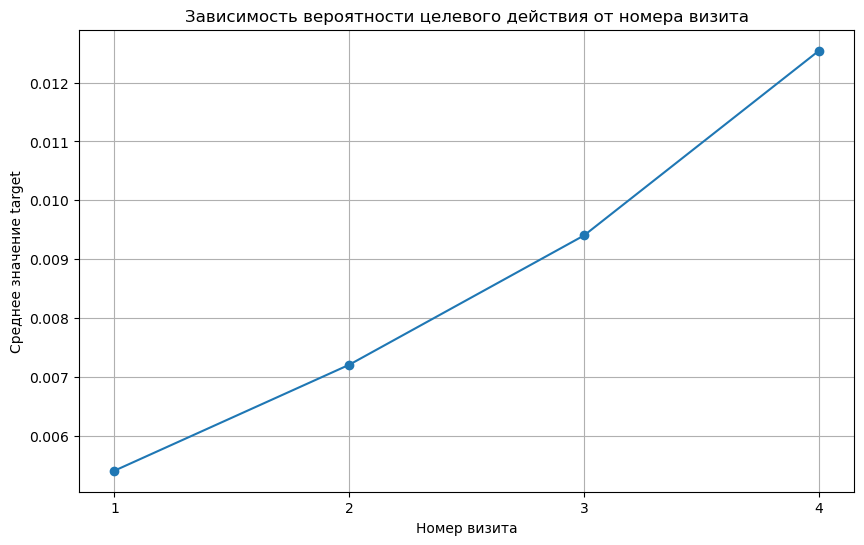

In [418]:
plot_average_target_by_visit(data)

# По графику мы четко видим зависимость, что чем больше человек заходит на ресурс, тем больше вероятность совершения целевого действия

# п. 26 Исследую данные utm_medium

In [163]:
data.utm_medium.value_counts

<bound method IndexOpsMixin.value_counts of 0           (none)
1          organic
2           banner
3           banner
4           banner
            ...   
4743893     (none)
4743894        cpm
4743895    organic
4743896        cpc
4743897     (none)
Name: utm_medium, Length: 4743898, dtype: object>

In [164]:
# Группируем по utm_medium и суммируем целевые значения
medium_counts = data.groupby('utm_medium')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_medium = medium_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_medium)

         utm_medium  target
5            banner    9018
13              cpc    6292
0            (none)    6026
37         referral    5125
14              cpm    1519
29          organic    1201
35             push     534
17            email     230
6   blogger_channel     156
12              cpa     102


In [165]:
# Определяем функцию для присвоения категорий
def classify_utm_medium(medium):
    high = ['banner', 'cpc', 'organic', 'referral', '(none)']
    medium_values = ['cpm', 'push']

    if medium in high:
        return 'high'
    elif medium in medium_values:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки medium_target
data['medium_target'] = data['utm_medium'].apply(classify_utm_medium)

In [166]:
# Определяем функцию для создания utm_medium_target
def get_medium_target(row):
    if (row['medium_target'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки utm_medium_target
data['utm_medium_target'] = data.apply(get_medium_target, axis=1)

In [167]:
# Функция для замены значений utm_medium
def replace_utm_medium_based_on_social_traffic(row):
    if row['medium_target'] == 'low':
        return 'unknown'
    return row['utm_medium']  # Возвращаем исходное значение, если условие не выполнено

# Применение функции к DataFrame
data['utm_medium'] = data.apply(replace_utm_medium_based_on_social_traffic, axis=1)
# Замена значений
data['utm_medium'] = data['utm_medium'].replace('(none)', 'organic')

# Сводная таблица

| Колонка utm_medium | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|banner|9018|high
|cpc|6292|high
|(none)|6026|high
|referral|5125|high
|cpm|1519|medium
|organic|1201|high
|push|534|medium
|email|230|low
|blogger_channel|156|low
|cpa|102|low
|  |  |  

## По условиям так же было разделение платного и органического трафика. Выведем их для обучения

In [168]:
# Определяем органический и платный трафик
data['traffic_type'] = 'paid'
data.loc[data['utm_medium'].isin(['organic', 'referral', '(none)']), 'traffic_type'] = 'organic'

In [169]:
# Группируем по traffic_type и суммируем целевые значения
traffic_counts = data.groupby('traffic_type')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_traffic = traffic_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_traffic)

  traffic_type  target
1         paid   18291
0      organic   12352


# п. 27 Исследую данные device_category

In [227]:
data.device_category.value_counts()

device_category
mobile     3510239
desktop    1189650
tablet       44009
Name: count, dtype: int64

# Визуализирую данные

In [428]:
def plot_countplot_device(data, x_col, title='Частота использования ресурса от разных видов источников', xlabel='Виды устройств', ylabel='Частота'):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x=x_col, order=data[x_col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Визуализация

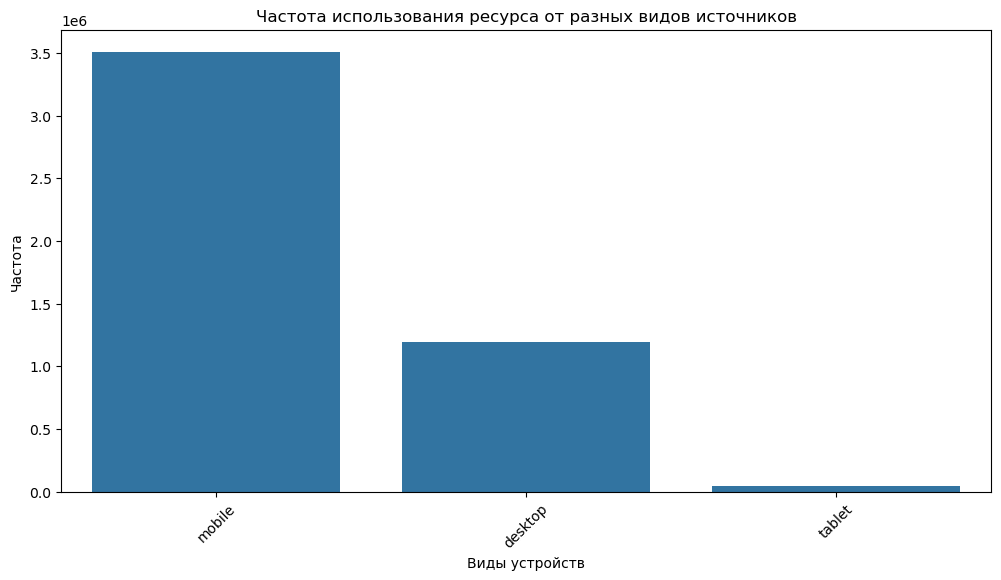

In [430]:
plot_countplot_device(data, 'device_category')

## Мы проводили похожее иследование. Количество использований с помощью телефона намного выше, что позволит направить средства в разработку и модернизацию именно мобильного приложения

# п. 28 Исследование колонки device_screen_resolution

In [231]:
data.device_screen_resolution.value_counts()

device_screen_resolution
414x896      447927
1920x1080    419769
375x812      314898
393x851      273420
375x667      227494
              ...  
1280x850          1
442x661           1
1879x1184         1
234x541           1
1918x926          1
Name: count, Length: 4153, dtype: int64

In [232]:
# Группируем по device_screen_resolution и суммируем целевые значения
resolution_counts = data.groupby('device_screen_resolution')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_resolution = resolution_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_resolution)

     device_screen_resolution  target
2881                  414x896    2512
940                 1920x1080    2253
1914                  375x812    1912
2299                  393x851    1791
2747                  412x915    1633
1871                  375x667    1431
1696                  360x800    1405
1676                  360x780    1374
2140                  390x844     934
1541                  360x640     920


In [442]:
# Определяем функцию для присвоения категорий
def classify_resolution(resolution):
    high = ['414x896','1920x1080','375x812']
    medium = ['393x851','393x851','412x915','375x667','360x800','360x780']
    
    if resolution in high:
        return 'high'
    elif resolution in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки device_screen_resolution_category
data['device_screen_resolution_category'] = data['device_screen_resolution'].apply(classify_resolution)

In [234]:
# Определяем функцию для создания resolution_target
def get_resolution(row):
    if (row['device_screen_resolution_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки resolution_target
data['resolution_target'] = data.apply(get_resolution, axis=1)

# Сводная таблица

| Колонка device_screen_resolution   | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|414x896|2512|high
|1920x1080|2253|high
|375x812|1912|high
|393x851|1791|medium
|412x915|1633|medium
|375x667|1431|medium
|360x800|1405|medium
|360x780|1374|medium
|390x844|934|low
|360x640|920|low
|  |  |  

# Визуализирую данные

In [438]:
def plot_pie_chart_resolution(data, column, title='Распределение разрешений экрана устройств'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

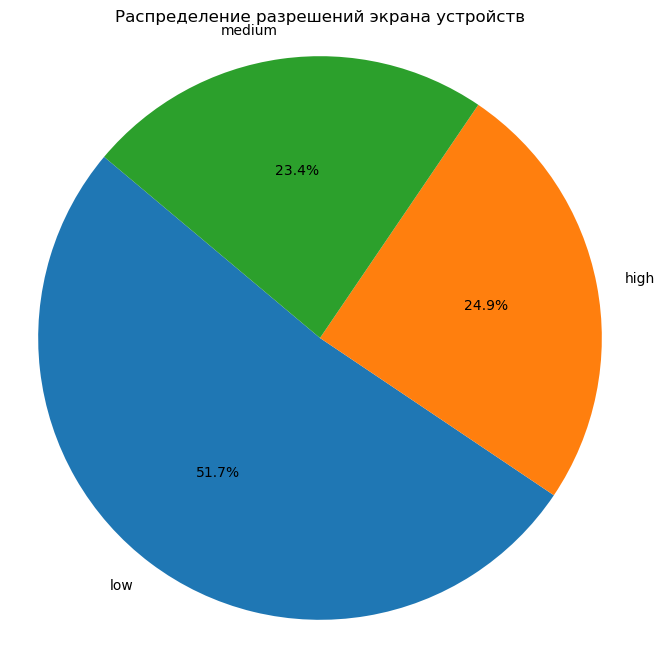

In [444]:
plot_pie_chart_resolution(data, 'device_screen_resolution_category')

## По диаграмме мы видим, что распределение устройств с различным разрешением в выборке достаточно велико и доля наиболее результативных из них равна половине всех значений

# п. 29 Исследование данных device_browser

In [236]:
data.device_browser.value_counts()

device_browser
Chrome                              2477652
Safari                              1274097
YaBrowser                            397316
Safari (in-app)                      192791
Android Webview                      139066
Samsung Internet                      79794
Firefox                               62378
Opera                                 59368
Edge                                  58567
UC Browser                             1540
[FBAN                                   223
Mozilla Compatible Agent                223
Android Runtime                         213
Instagram 208.0.0.32.135 Android        110
Instagram 209.0.0.21.119 Android         95
MRCHROME                                 93
Puffin                                   67
Mozilla                                  41
com.vk.vkclient                          30
Maxthon                                  29
Internet Explorer                        26
Opera Mini                               24
Android Browser  

In [238]:
# Группируем по device_browser и суммируем целевые значения
browser_counts = data.groupby('device_browser')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_browser = browser_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_browser)

      device_browser  target
6             Chrome   17024
41            Safari    7894
46         YaBrowser    2463
5    Android Webview     958
43  Samsung Internet     681
42   Safari (in-app)     601
9            Firefox     401
8               Edge     299
37             Opera     293
45        UC Browser      26


In [453]:
# Определяем функцию для присвоения категорий
def classify_browser(browser):
    high = ['Chrome']
    medium = ['Safari','YaBrowser']
    
    if browser in high:
        return 'high'
    elif browser in medium:
        return 'medium'
    else:
        return 'low'

# Применяем функцию для создания новой колонки device_browser_category
data['device_browser_category'] = data['device_browser'].apply(classify_browser)

In [454]:
# Определяем функцию для создания browser_target
def get_browser(row):
    if (row['device_browser_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки browser_target
data['browser_target'] = data.apply(get_browser, axis=1)

In [455]:
data.loc[data['browser_target'] == 0, 'device_browser'] = 'unknown'

# Сводная таблица

| Колонка device_browser| Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|Chrome|17024|high
|Safari|7894|medium
|YaBrowser|2463|medium
|Android Webview|958|low
|Samsung Internet|681|low
|Safari (in-app)|601|low
|Firefox|401|low
|Edge|299|low
|Opera|293|low
|UC Browser |26|low
|  |  |  

# Визуализирую данные

In [459]:
def plot_pie_chart_browser(data, column, title='Распределение видов браузеров пользователей'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

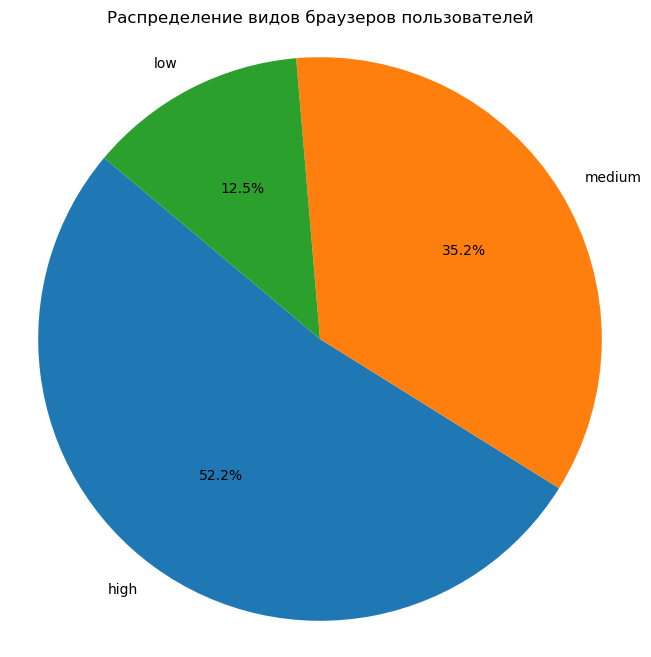

In [464]:
plot_pie_chart_browser(data, 'device_browser_category')

# На диаграмме мы видим, что на устройствах пользователей преобладает браузер Chrome. Если организовать взаимодействие именно с этой компанией, то это может увеличить прибыль компании

# п. 30 Исследование колонки geo_country

In [246]:
data.geo_country.value_counts()

geo_country
Russia               4616561
Ukraine                23009
United States          11617
Belarus                 9129
Germany                 7607
                      ...   
Antigua & Barbuda          2
Guinea                     2
Ghana                      1
Costa Rica                 1
Barbados                   1
Name: count, Length: 155, dtype: int64

In [247]:
# Группируем по geo_country и суммируем целевые значения
country_counts = data.groupby('geo_country')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_country = country_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_country)

        geo_country  target
115          Russia   30087
145         Ukraine     100
48          Germany      47
70       Kazakhstan      34
148   United States      30
16          Belarus      27
142          Turkey      22
147  United Kingdom      21
73       Kyrgyzstan      18
47          Georgia      17


In [473]:
# Определяем функцию для присвоения категорий
def classify_country(country):
    high = ['Russia']
    
    if country in high:
        return 'high'
    else:
        return 'low'

# Применяем функцию для создания новой колонки country_category
data['country_category'] = data['geo_country'].apply(classify_country)

In [ ]:
# Определяем функцию для создания country_target
def get_country(row):
    if (row['country_category'] in ['high']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки country_target
data['country_target'] = data.apply(get_country, axis=1)

In [476]:
data.loc[data['country_target'] == 0, 'geo_country'] = 'unknown'

# Сводная таблица

| Колонка geo_country  | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|Russia|30087|high
|Ukraine|100|low
|Germany|47|low
|Kazakhstan|34|low
|United States|30|low
|Belarus|27|low
|Turkey|22|low
|United Kingdom|21|low
|Kyrgyzstan|18|low
|Georgia|17|low
|  |  |  

# Визуализирую данные

In [478]:
def plot_pie_chart_country(data, column, title='Распределение стран пользователей'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

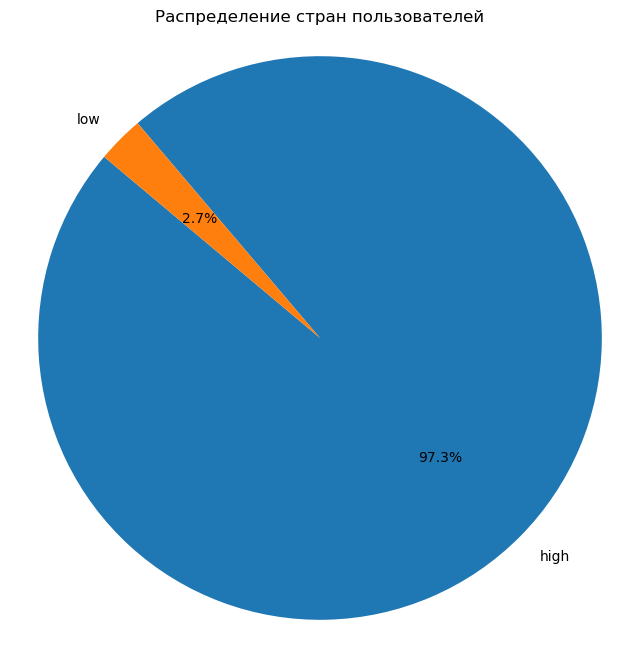

In [480]:
plot_pie_chart_country(data,'country_category')

## Как мы видим по диаграмме, количество пользователей с Russia значительно превышает остальные. т.к. нет данных об использовании приложении за рубежом мы категорируем данные на основные и которые нам менее нужны

# п. 31 Исследование данных geo_city

In [252]:
data.geo_city.value_counts()

geo_city
Moscow               2055314
Saint Petersburg      715090
(not set)             180229
Yekaterinburg          99341
Krasnodar              88483
                      ...   
Yamaguchi                  1
Waldbrol                   1
Bobo-Dioulasso             1
Humanes de Madrid          1
Ridgefield Park            1
Name: count, Length: 2110, dtype: int64

In [253]:
# Группируем по geo_city и суммируем целевые значения
city_counts = data.groupby('geo_city')['target'].sum().reset_index()

# Сортируем кампании по количеству вхождений в целевую переменную в порядке убывания
top_city = city_counts.sort_values(by='target', ascending=False).head(10)

# Вывод результата
print(top_city)

              geo_city  target
1201            Moscow   15257
1606  Saint Petersburg    4102
1            (not set)     879
840              Kazan     742
935          Krasnodar     635
2053     Yekaterinburg     484
1620            Samara     433
1902               Ufa     406
1285   Nizhny Novgorod     307
1319       Novosibirsk     288


In [490]:
# Определяем функцию для присвоения категорий
def classify_city(city):
    high = ['Moscow', '(not_set)']
    medium = ['Saint Petersburg']
    if city in high:
        return 'high'
    if city in medium:
        return 'medium'    
    else:
        return 'low'

# Применяем функцию для создания новой колонки city_category
data['city_category'] = data['geo_city'].apply(classify_city)

In [492]:
# Определяем функцию для создания city_target
def get_city(row):
    if (row['city_category'] in ['high', 'medium']) and (row['target'] == 1):
        return 1
    else:
        return 0

# Применяем функцию для создания новой колонки city_target
data['city_target'] = data.apply(get_city, axis=1)

In [493]:
data.loc[data['city_target'] == 0, 'geo_city'] = 'unknown'

# Сводная таблица

| Колонка geo_city | Количество вхождений целевой переменной | Новая переменная
|---|:---|---|
|Moscow|15257|high
|Saint Petersburg|4102|medium
|(not set)|879|low
|Kazan|742|low
|Krasnodar |635|low
|Yekaterinburg|484|low
|Samara|433|low
|Ufa|406|low
|Nizhny Novgorod|307|low
|Novosibirsk|288|low
|  |  |  

# Визуализация данных

In [494]:
def plot_pie_chart_city(data, column, title='Распределение городов пользователей'):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Визуализация

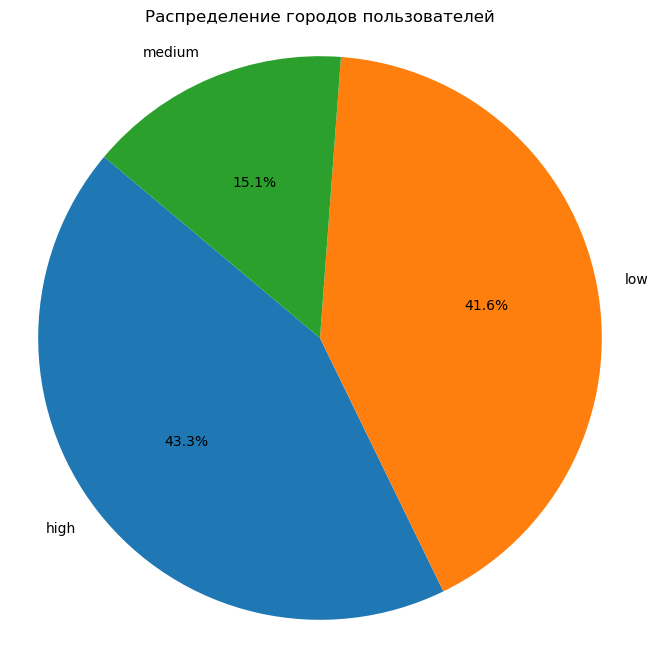

In [500]:
plot_pie_chart_city(data, 'city_category')

## По диаграмме мы видим, что общий объем пользователей с Москвы и СПб чуть больше остальной части страны. Для лучшего обучения выделим эти два города из общей массы, а так же имеем ввиду что основной доход приносит именно Москва

# п. 32 Итоговая проверка данных

In [258]:
data.columns

Index(['session_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
       'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'hit_date', 'hit_time', 'hit_number', 'hit_referer', 'hit_page_path',
       'event_category', 'event_action', 'event_label', 'target',
       'utm_source_classification', 'source_target', 'media_company',
       'media_target', 'media_adcontents', 'media_adcontents_target',
       'media_keyword', 'media_keyword_target', 'device_brand_category',
       'device_brand_target', 'device_os_category', 'device_os_target',
       'is_mobile', 'is_desktop', 'is_tablet', 'referer_category',
       'referer_target', 'car_brand', 'car_model', 'car_brand_category',
       'car_brand_target', 'car_model_category', 'car_model_target',
       'event_category_classify', 'event_category_target',
       'event_label_c

|№ п\п| Название колонки | Отметка об обработке | Состояние колонки
|---|---|:---|---|
1|session_id|+| Строки проверены
2|client_id|-| Удалено
3|visit_date|+| Строки проверены
4|visit_time|+| Выбросы удалены
5|visit_number|+| Выбросы удалены
6|utm_source|+| Строки категорированы
7|utm_medium|+| Строки категорированы
8|utm_campaign|+| Строки категорированы
9|utm_adcontent|+| Строки категорированы
10|utm_keyword|+| Строки категорированы
11|device_category|+| Строки категорированы
12|device_os|+| Строки категорированы
13|device_brand|+| Строки категорированы
14|device_model|-| Удалено
15|device_screen_resolution|+| Строки категорированы
16|device_browser|+| Строки категорированы
17|geo_country|+| Строки категорированы
18|geo_city|+| Строки категорированы
19|hit_date|+| Строки проверены
20|hit_time|+| Строки проверены, выбросы удалены
21|hit_number|+| Строки проверены, заменены медианой
22|hit_type|-| Удалено
23|hit_referer|+| Строки категорированы
24|hit_page_path|-| Удалено
25|event_category|+| Строки категорированы
26|event_action|+| Строки категорированы
27|event_label|+| Строки категорированы
28|event_value|-| Удалено
29|target|+| Строки категорированы
30|utm_source_classification|+| Строки категорированы
31|source_target|+| Строки категорированы
32|media_company|+| Строки категорированы
33|media_target|+| Строки категорированы
34|media_adcontents|+| Строки категорированы
35|media_adcontents_target|+| Строки категорированы
36|media_keyword|+| Строки категорированы
37|media_keyword_target|+| Строки категорированы
38|device_brand_category|+| Строки категорированы
39|device_brand_target|+| Строки категорированы
40|device_os_category|+| Строки категорированы
41|device_os_target|+| Строки категорированы
42|is_mobile|+| Строки категорированы
43|is_desktop|+| Строки категорированы
44|is_tablet|+| Строки категорированы
45|referer_category|+| Строки категорированы
46|referer_target|+| Строки категорированы
47|car_brand|-| Удалено
48|car_model|-| Удалено
49|car_brand_category|-| Удалено
50|car_brand_target|-| Удалено
51|car_model_category|-| Удалено
52|car_model_target|-| Удалено
53|event_category_classify|+| Строки категорированы
54|event_category_target|+| Строки категорированы
55|event_label_classify|+| Строки категорированы
56|event_label_category_target|+| Строки категорированы
57|day_of_week|+| Строки категорированы
58|hour_of_day|+| Строки категорированы
59|is_monday|+| Строки категорированы
60|is_tuesday|+| Строки категорированы
61|is_traffic_time|+| Строки категорированы
62|visit_category|+| Строки категорированы
63|visit_category_target|+| Строки категорированы
64|medium_target|+| Строки категорированы
65|utm_medium_target|+| Строки категорированы
66|traffic_type|+| Строки категорированы
67|device_screen_resolution_category|+| Строки категорированы
68|resolution_target|+| Строки категорированы
69|device_browser_category|+| Строки категорированы
70|browser_target|+| Строки категорированы
71|country_category|+| Строки категорированы
72|country_target|+| Строки категорированы
73|city_category|+| Строки категорированы
74|city_target|+| Строки категорированы
|  |  |  

# Здесь списки всех значений колонок

In [260]:
unique_values = data['visit_date'].unique()
print("Уникальные значения в 'visit_date':", unique_values)

Уникальные значения в 'visit_date': <DatetimeArray>
['2021-09-12 00:00:00', '2021-06-08 00:00:00', '2021-12-11 00:00:00',
 '2021-10-06 00:00:00', '2021-06-11 00:00:00', '2021-07-16 00:00:00',
 '2021-08-21 00:00:00', '2021-08-06 00:00:00', '2021-08-14 00:00:00',
 '2021-07-27 00:00:00',
 ...
 '2021-09-17 00:00:00', '2021-06-13 00:00:00', '2021-06-17 00:00:00',
 '2021-07-06 00:00:00', '2021-05-29 00:00:00', '2021-06-20 00:00:00',
 '2021-07-21 00:00:00', '2021-07-24 00:00:00', '2021-08-11 00:00:00',
 '2021-05-22 00:00:00']
Length: 226, dtype: datetime64[ns]


In [261]:
unique_values = data['visit_time'].unique()
print("Уникальные значения в 'visit_time':", unique_values)

Уникальные значения в 'visit_time': ['23:00:00' '12:00:00' '12:26:29' ... '03:49:52' '02:36:00' '05:46:28']


In [262]:
unique_values = data['visit_number'].unique()
print("Уникальные значения в 'visit_number':", unique_values)

Уникальные значения в 'visit_number': [1 2 4 3]


In [263]:
unique_values = data['utm_source'].unique()
print("Уникальные значения в 'utm_source':", unique_values)

Уникальные значения в 'utm_source': ['fDLlAcSmythWSCVMvqvL' 'kjsLglQLzykiRbcDiGcD' 'ZpYIoDJMcFzVoPFsHGJL'
 'bByPQxmDaMXgpHeypKSM' 'unknown' 'QxAxdyPLuQMEcrdZWdWb'
 'MvfHsxITijuriZxsqZqt' 'IZEXUFLARCUMynmHNBGo' 'ISrKoXQCxqqYvAZICvjs'
 'PlbkrSYoHuZBWfYjYnfw' 'gVRrcxiDQubJiljoTbGm']


In [264]:
unique_values = data['utm_medium'].unique()
print("Уникальные значения в 'utm_medium':", unique_values)

Уникальные значения в 'utm_medium': ['organic' 'banner' 'cpc' 'referral' 'unknown' 'push' 'cpm']


In [265]:
unique_values = data['utm_campaign'].unique()
print("Уникальные значения в 'utm_campaign':", unique_values)

Уникальные значения в 'utm_campaign': ['unknown' 'LTuZkdKfxRGVceoWkVyg' 'FTjNLDyTrXaWYgZymFkV'
 'LEoPHuyFvzoNfnzGgfcd' 'gecBYcKZCPMcVYdSSzKP']


In [266]:
unique_values = data['utm_adcontent'].unique()
print("Уникальные значения в 'utm_adcontent':", unique_values)

Уникальные значения в 'utm_adcontent': ['unknown' 'JNHcPlZPxEMWDnRiyoBf' 'vCIpmpaGBnIQhyYNkXqp']


In [267]:
unique_values = data['utm_keyword'].unique()
print("Уникальные значения в 'utm_keyword':", unique_values)

Уникальные значения в 'utm_keyword': ['unknown' 'puhZPIYqKXeFPaUviSjo' 'ITfrGJNwVsHBGJMAKoct'
 'hAmNSZmQkKQKAjZEGlgb']


In [268]:
unique_values = data['device_category'].unique()
print("Уникальные значения в 'device_category':", unique_values)

Уникальные значения в 'device_category': ['mobile' 'desktop' 'tablet']


In [269]:
unique_values = data['device_os'].unique()
print("Уникальные значения в 'device_os':", unique_values)

Уникальные значения в 'device_os': ['unknown' 'Android' 'Macintosh' 'Windows' 'iOS']


In [270]:
unique_values = data['device_brand'].unique()
print("Уникальные значения в 'device_brand':", unique_values)

Уникальные значения в 'device_brand': ['Apple' 'unknown' 'Xiaomi' 'Huawei' 'Samsung' 'OPPO' 'Vivo' 'Realme']


In [271]:
unique_values = data['device_screen_resolution'].unique()
print("Уникальные значения в 'device_screen_resolution':", unique_values)

Уникальные значения в 'device_screen_resolution': ['414x896' '1920x1080' '360x780' ... '1344x601' '1050x1680' '1918x926']


In [272]:
unique_values = data['device_browser'].unique()
print("Уникальные значения в 'device_browser':", unique_values)

Уникальные значения в 'device_browser': ['unknown' 'Chrome' 'Safari' 'YaBrowser']


In [273]:
unique_values = data['geo_country'].unique()
print("Уникальные значения в 'geo_country':", unique_values)

Уникальные значения в 'geo_country': ['unknown' 'Russia']


In [274]:
unique_values = data['geo_city'].unique()
print("Уникальные значения в 'geo_city':", unique_values)

Уникальные значения в 'geo_city': ['unknown' 'Moscow' 'Saint Petersburg']


In [275]:
unique_values = data['hit_date'].unique()
print("Уникальные значения в 'hit_date':", unique_values)

Уникальные значения в 'hit_date': ['2021-09-12' '2021-06-08' '2021-12-11' '2021-10-06' '2021-06-11'
 '2021-07-16' '2021-08-21' '2021-08-06' '2021-08-14' '2021-07-27'
 '2021-05-24' '2021-12-25' '2021-07-17' '2021-06-15' '2021-12-26'
 '2021-11-13' '2021-10-25' '2021-11-19' '2021-12-12' '2021-09-13'
 '2021-10-03' '2021-11-17' '2021-08-05' '2021-12-24' '2021-12-14'
 '2021-05-25' '2021-08-29' '2021-12-16' '2021-10-15' '2021-10-04'
 '2021-07-07' '2021-11-10' '2021-10-26' '2021-11-21' '2021-09-21'
 '2021-09-27' '2021-11-14' '2021-07-02' '2021-05-27' '2021-11-06'
 '2021-12-23' '2021-09-23' '2021-12-20' '2021-09-30' '2021-12-13'
 '2021-09-05' '2021-06-09' '2021-09-01' '2021-09-19' '2021-12-21'
 '2021-10-21' '2021-12-18' '2021-07-05' '2021-11-16' '2021-10-23'
 '2021-09-24' '2021-05-31' '2021-11-28' '2021-07-30' '2021-10-14'
 '2021-05-21' '2021-06-29' '2021-12-08' '2021-09-14' '2021-07-22'
 '2021-12-27' '2021-11-29' '2021-06-21' '2021-11-23' '2021-11-05'
 '2021-09-16' '2021-12-28' '2021-08-28' '2

In [276]:
unique_values = data['hit_time'].unique()
print("Уникальные значения в 'hit_time':", unique_values)

Уникальные значения в 'hit_time': [149617.26611966 218252.         426253.         ... 420801.
 455077.         130805.        ]


In [277]:
unique_values = data['hit_number'].unique()
print("Уникальные значения в 'hit_number':", unique_values)

Уникальные значения в 'hit_number': [ 37.  26.   7.  22.  12.  14.  15.   3.  60.  47.  36.  30.  20.   8.
   2.  28.   9.  18.  25. 115.  13.  17.  27.   4.  29.  11.   6.  53.
  10.  21.  46.  24.  39.  32.  62.  23.  43.  19. 121.  16.  33. 107.
   5.  55.  74. 137.   1.  75.  70.  40.  50.  80. 125.  41. 122.  31.
  44.  45. 148.  52.  48. 108.  85.  77.  65.  83. 106.  34.  35.  63.
  56.  51. 104.  42.  61.  38.  57.  76.  68. 389.  66. 112.  82. 171.
 127.  69. 130.  93. 103.  58.  81. 264.  91.  59.  84.  54. 145.  95.
  49. 129.  71.  97.  86. 249. 188.  78. 119.  67.  73. 147. 102.  99.
 160.  96. 144. 151.  94. 263.  89.  79.  64.  98. 120. 111. 211. 269.
 180. 245. 163. 114. 169. 275. 105. 155. 320. 101. 239. 113.  72. 164.
 222. 158. 124.  87. 168. 140. 173. 131.  92. 184. 170.  88. 136. 109.
 208. 445. 156. 139. 338. 146. 150. 190. 493. 141. 209. 398. 373. 133.
 162. 123. 161. 128. 135. 126.  90. 132. 228. 159. 118. 192. 157. 134.
 292. 165. 116. 422. 214. 117. 295. 100. 

In [278]:
unique_values = data['hit_referer'].unique()
print("Уникальные значения в 'hit_referer':", unique_values)

Уникальные значения в 'hit_referer': ['unknown' 'HbolMJUevblAbkHClEQa']


In [279]:
unique_values = data['hit_page_path'].unique()
print("Уникальные значения в 'hit_page_path':", unique_values)

Уникальные значения в 'hit_page_path': ['unknown'
 'sberauto.com/cars/all/volkswagen/polo/e994838f?utm_source_initial=yandex&utm_medium_initial=cpc&utm_campaign_initial=nSReTmyFtbSjlPrTKoaX|fVHJqnfOFSWcsCBViJGr&utm_content_initial=yXzSAJWSuRbYeLFyMVFl|YjagTPsykUtMSrHgFPJc|xAEYTlJDbQNwQTLGxICQ|dwfnIkMEwJhmnyojmAoc|lFpAoUqEvHoyZfCNRuCR|xhyCpuqkchncMsrZwjte|rjbbNGNkjGThUJNtsWZQ|keedlzvGXaPexcIGqprx|ZIKCVYXYgRrZdwlVkEEf|HbolMJUevblAbkHClEQa|kqZPVvZmXADsCZxIQwbv|vnTlRpYmthtVDImMLSmr|OfdDOXSwHYclonQJpPxh|YhdYMAYSoTzDKQYzVVMr|HbolMJUevblAbkHClEQa&utm_term_initial=&rental_page=rental_car'
 'sberauto.com/cars/all/skoda/rapid/bf24b977?utm_source_initial=sbol&utm_medium_initial=banner&utm_campaign_initial=LEoPHuyFvzoNfnzGgfcd&utm_content_initial=vCIpmpaGBnIQhyYNkXqp&rental_page=rental_car'
 'sberauto.com/cars/all/skoda/rapid/bf24b977?utm_source_initial=yandex&utm_medium_initial=cpc&utm_campaign_initial=nSReTmyFtbSjlPrTKoaX|fVHJqnfOFSWcsCBViJGr&utm_content_initial=yXzSAJWSuRbYeLFyMVFl|YjagTPsykUtM

In [280]:
unique_values = data['event_category'].unique()
print("Уникальные значения в 'event_category':", unique_values)

Уникальные значения в 'event_category': ['unknown' 'sub_button_click' 'sub_submit']


In [281]:
unique_values = data['event_action'].unique()
print("Уникальные значения в 'event_action':", unique_values)

Уникальные значения в 'event_action': ['unknown' 'sub_open_dialog_click' 'sub_car_claim_click'
 'sub_car_request_submit_click' 'sub_car_claim_submit_click'
 'sub_submit_success' 'sub_call_number_click' 'sub_callback_submit_click'
 'sub_custom_question_submit_click']


In [282]:
unique_values = data['event_label'].unique()
print("Уникальные значения в 'event_label':", unique_values)

Уникальные значения в 'event_label': ['unknown' 'DrwJcHfmgRDbfayCKOrQ' 'EsLbNNEnCkXWoaesnKlS'
 'ZaZuwAXOKlbzyhUqtnmk' 'KuMiABMMbspIDDhiCNVS' 'nsPPIRqjxBefONGPpnsF'
 'KclpemfoHstknWHFiLit']


In [283]:
unique_values = data['target'].unique()
print("Уникальные значения в 'target':", unique_values)

Уникальные значения в 'target': [0 1]


In [386]:
unique_values = data['utm_source_classification'].unique()
print("Уникальные значения в 'utm_source_classification':", unique_values)

Уникальные значения в 'utm_source_classification': ['high' 'medium' 'low' 'social']


In [388]:
unique_values = data['source_target'].unique()
print("Уникальные значения в 'source_target':", unique_values)

Уникальные значения в 'source_target': [1 0]


In [317]:
unique_values = data['media_company'].unique()
print("Уникальные значения в 'media_company':", unique_values)

Уникальные значения в 'media_company': ['high' 'medium' 'low']


In [318]:
unique_values = data['media_target'].unique()
print("Уникальные значения в 'media_target':", unique_values)

Уникальные значения в 'media_target': [0 1]


In [321]:
unique_values = data['media_adcontents'].unique()
print("Уникальные значения в 'media_adcontents':", unique_values)

Уникальные значения в 'media_adcontents': ['high' 'medium' 'low']


In [323]:
unique_values = data['media_adcontents_target'].unique()
print("Уникальные значения в 'media_adcontents_target':", unique_values)

Уникальные значения в 'media_adcontents_target': [0 1]


In [324]:
unique_values = data['media_keyword'].unique()
print("Уникальные значения в 'media_keyword':", unique_values)

Уникальные значения в 'media_keyword': ['low' 'high' 'medium']


In [325]:
unique_values = data['media_keyword_target'].unique()
print("Уникальные значения в 'media_keyword_target':", unique_values)

Уникальные значения в 'media_keyword_target': [0 1]


In [328]:
unique_values = data['device_brand_category'].unique()
print("Уникальные значения в 'device_brand_category':", unique_values)

Уникальные значения в 'device_brand_category': ['high' 'low' 'medium']


In [329]:
unique_values = data['device_brand_target'].unique()
print("Уникальные значения в 'device_brand_target':", unique_values)

Уникальные значения в 'device_brand_target': [1 0]


In [326]:
unique_values = data['device_os_category'].unique()
print("Уникальные значения в 'device_os_category':", unique_values)

Уникальные значения в 'device_os_category': ['low' 'high' 'medium']


In [327]:
unique_values = data['device_os_target'].unique()
print("Уникальные значения в 'device_os_target':", unique_values)

Уникальные значения в 'device_os_target': [0 1]


In [363]:
unique_values = data['is_mobile'].unique()
print("Уникальные значения в 'is_mobile':", unique_values)

Уникальные значения в 'is_mobile': [0 1]


In [365]:
unique_values = data['is_desktop'].unique()
print("Уникальные значения в 'is_desktop':", unique_values)

Уникальные значения в 'is_desktop': [0 1]


In [367]:
unique_values = data['is_tablet'].unique()
print("Уникальные значения в 'is_tablet':", unique_values)

Уникальные значения в 'is_tablet': [0 1]


In [353]:
unique_values = data['referer_category'].unique()
print("Уникальные значения в 'referer_category':", unique_values)

Уникальные значения в 'referer_category': ['high' 'low']


In [371]:
unique_values = data['referer_target'].unique()
print("Уникальные значения в 'referer_target':", unique_values)

Уникальные значения в 'referer_target': [0 1]


In [354]:
unique_values = data['car_brand'].unique()
print("Уникальные значения в 'car_brand':", unique_values)

Уникальные значения в 'car_brand': ['unknown' 'mercedes-benz' 'lada' 'porsche' 'kia' 'skoda' 'nissan' 'bmw'
 'volkswagen' 'renault' 'toyota' 'ford' 'honda']


In [355]:
unique_values = data['car_model'].unique()
print("Уникальные значения в 'car_model':", unique_values)

Уникальные значения в 'car_model': ['unknown' 'vesta' 'cayenne' 'sorento' 'x-trail' 'polo' '2-serii' 'logan'
 'x3' 'qashqai' 'camry' 'tiguan' 'x5' 'corolla' 'touareg' 'focus' 'accord'
 'civic' 'cr-v' 'mustang']


In [390]:
unique_values = data['car_brand_category'].unique()
print("Уникальные значения в 'car_brand_category':", unique_values)

Уникальные значения в 'car_brand_category': ['low' 'medium' 'high']


In [394]:
unique_values = data['car_brand_target'].unique()
print("Уникальные значения в 'car_brand_target':", unique_values)

Уникальные значения в 'car_brand_target': [0 1]


In [392]:
unique_values = data['car_model_category'].unique()
print("Уникальные значения в 'car_model_category':", unique_values)

Уникальные значения в 'car_model_category': ['low' 'high' 'medium']


In [396]:
unique_values = data['car_model_target'].unique()
print("Уникальные значения в 'car_model_target':", unique_values)

Уникальные значения в 'car_model_target': [0 1]


In [375]:
unique_values = data['event_category_classify'].unique()
print("Уникальные значения в 'event_category_classify':", unique_values)

Уникальные значения в 'event_category_classify': ['high' 'low' 'medium']


In [373]:
unique_values = data['event_category_target'].unique()
print("Уникальные значения в 'event_category_target':", unique_values)

Уникальные значения в 'event_category_target': [0 1]


In [377]:
unique_values = data['event_label_classify'].unique()
print("Уникальные значения в 'event_label_classify':", unique_values)

Уникальные значения в 'event_label_classify': ['medium' 'low' 'high']


In [379]:
unique_values = data['event_label_category_target'].unique()
print("Уникальные значения в 'event_label_category_target':", unique_values)

Уникальные значения в 'event_label_category_target': [0 1]


In [307]:
unique_values = data['day_of_week'].unique()
print("Уникальные значения в 'day_of_week':", unique_values)

Уникальные значения в 'day_of_week': [6 1 5 2 4 0 3]


In [309]:
unique_values = data['hour_of_day'].unique()
print("Уникальные значения в 'hour_of_day':", unique_values)

Уникальные значения в 'hour_of_day': [23 12  9 20 18  0 10 16 19 11  3  7 17 21 14 22  8  1 15 13  5  4  6  2]


In [311]:
unique_values = data['is_monday'].unique()
print("Уникальные значения в 'is_monday':", unique_values)

Уникальные значения в 'is_monday': [0 1]


In [313]:
unique_values = data['is_tuesday'].unique()
print("Уникальные значения в 'is_tuesday':", unique_values)

Уникальные значения в 'is_tuesday': [0 1]


In [315]:
unique_values = data['is_traffic_time'].unique()
print("Уникальные значения в 'is_traffic_time':", unique_values)

Уникальные значения в 'is_traffic_time': [0 1]


In [303]:
unique_values = data['visit_category'].unique()
print("Уникальные значения в 'visit_category':", unique_values)

Уникальные значения в 'visit_category': ['low' 'medium' 'expert' 'high']


In [305]:
unique_values = data['visit_category_target'].unique()
print("Уникальные значения в 'visit_category_target':", unique_values)

Уникальные значения в 'visit_category_target': [0 1]


In [383]:
unique_values = data['medium_target'].unique()
print("Уникальные значения в 'medium_target':", unique_values)

Уникальные значения в 'medium_target': ['high' 'low' 'medium']


In [398]:
unique_values = data['utm_medium_target'].unique()
print("Уникальные значения в 'utm_medium_target':", unique_values)

Уникальные значения в 'utm_medium_target': [0 1]


In [284]:
unique_values = data['traffic_type'].unique()
print("Уникальные значения в 'traffic_type':", unique_values)

Уникальные значения в 'traffic_type': ['organic' 'paid']


In [330]:
unique_values = data['device_screen_resolution_category'].unique()
print("Уникальные значения в 'device_screen_resolution_category':", unique_values)

Уникальные значения в 'device_screen_resolution_category': ['high' 'low' 'medium']


In [339]:
unique_values = data['resolution_target'].unique()
print("Уникальные значения в 'resolution_target':", unique_values)

Уникальные значения в 'resolution_target': [0 1]


In [340]:
unique_values = data['device_browser_category'].unique()
print("Уникальные значения в 'device_browser_category':", unique_values)

Уникальные значения в 'device_browser_category': ['medium' 'high' 'low']


In [341]:
unique_values = data['browser_target'].unique()
print("Уникальные значения в 'browser_target':", unique_values)

Уникальные значения в 'browser_target': [0 1]


In [342]:
unique_values = data['country_category'].unique()
print("Уникальные значения в 'country_category':", unique_values)

Уникальные значения в 'country_category': ['high' 'low']


In [343]:
unique_values = data['country_target'].unique()
print("Уникальные значения в 'country_target':", unique_values)

Уникальные значения в 'country_target': [0 1]


In [344]:
unique_values = data['city_category'].unique()
print("Уникальные значения в 'city_category':", unique_values)

Уникальные значения в 'city_category': ['high' 'low' 'medium']


In [351]:
unique_values = data['city_target'].unique()
print("Уникальные значения в 'city_target':", unique_values)

Уникальные значения в 'city_target': [0 1]


# Сохранение датасета для обучения модели

In [416]:
data.to_csv('step_2.csv', index=False)